In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms, rdmolops
import os
import fnmatch
import numpy as np
import deepchem as dc
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GMM
import random
from tflearn.activations import leaky_relu
from deepchem.utils.rdkit_util import get_xyz_from_mol
from deepchem.feat.rdkit_grid_featurizer import convert_atom_to_voxel, compute_centroid, rotate_molecules
np.set_printoptions(precision=4)

In [2]:
from deepchem.feat.graph_features import ConvMolFeaturizer
from deepchem.feat.adjacency_fingerprints import AdjacencyFingerprint

In [429]:
def featurize_mols(mol_files, max_n_atoms, n_bonds=5, get_angle=True):
    featurizer = AdjacencyFingerprint(max_n_atoms=max_n_atoms)
    features = []
    for idx, mol_file in enumerate(mol_files):
        if idx % 32 == 0:
            print(idx)
        try:
            if ".pdb" in mol_file:
                mol = Chem.MolFromPDBFile(mol_file)
            elif "mol" in mol_file:
                mol = Chem.MolFromMol2File(mol_file)
            else:
                get_angle = False
                mol = Chem.MolFromSmiles(mol_file)
            if mol is None:
                features.append(None)
                continue
            
            if get_angle:
                mol_xyz = get_xyz_from_mol(mol)
                centroid = compute_centroid(mol_xyz)
                mol_xyz -= centroid
                temp = np.zeros((max_n_atoms, 3))
                try:
                    temp[:mol_xyz.shape[0]] = mol_xyz
                except:
                    features.append(None)
                    continue
                mol_xyz = temp
                c = mol.GetConformer(0)

            else:
                mol_xyz = np.zeros((max_n_atoms,3))
                AllChem.EmbedMultipleConfs(mol, 1)
                c = mol.GetConformer(0)
                for aid in range(mol.GetNumAtoms()):
                    pos = c.GetAtomPosition(aid)
                    mol_xyz[aid] = [pos.x, pos.y, pos.z]

            torsions = []
            torsion_tuples = []

            torsion_matrix = np.zeros((n_bonds,1))
            torsion_indices = np.zeros((n_bonds, max_n_atoms, 4)).astype(np.uint8)
            subgraphs = np.zeros((n_bonds, max_n_atoms, max_n_atoms)).astype(np.uint8)
            atom_index_of_bond = np.zeros((n_bonds, max_n_atoms)).astype(np.uint8)
            rot_vectors = np.zeros((n_bonds, 3))
            
            #mol_xyz = rotate_molecules([mol_xyz])[0]

            idx = 0
            for bond in mol.GetBonds():
                if bond.IsInRing(): 
                    continue
                def calc_torsions(atom_i, atom_j, bond_idx):        
                    exist_dihed = False
                    for neighbor_j in atom_j.GetNeighbors():
                        if neighbor_j.GetIdx() == atom_i.GetIdx():
                            continue

                        dihed_idx = 0
                        for neighbor_i in atom_i.GetNeighbors():
                            if neighbor_i.GetIdx() == atom_j.GetIdx():
                                continue

                            exist_dihed=True
                            torsion_tuple = (neighbor_i.GetIdx(), atom_i.GetIdx(), atom_j.GetIdx(), neighbor_j.GetIdx())

                            if get_angle:
                                torsion_matrix[bond_idx][dihed_idx] = rdMolTransforms.GetDihedralRad(c, *torsion_tuple)
                            torsion_indices[bond_idx][torsion_tuple[0]][dihed_idx*4] = 1
                            torsion_indices[bond_idx][torsion_tuple[1]][dihed_idx*4+1] = 1
                            torsion_indices[bond_idx][torsion_tuple[2]][dihed_idx*4+2] = 1
                            torsion_indices[bond_idx][torsion_tuple[3]][dihed_idx*4+3] = 1
                            
                            broken_mol = rdmolops.FragmentOnBonds(mol, [bond.GetIdx()], addDummies=False)
                            molfrags = rdmolops.GetMolFrags(broken_mol)
                            if bond.GetEndAtom().GetIdx() in molfrags[0]:
                                atoms_to_rotate = molfrags[0]
                            else:
                                atoms_to_rotate = molfrags[1]


                            subgraph = np.zeros((max_n_atoms, max_n_atoms)).astype(np.uint8)
                            for atom_idx in atoms_to_rotate:
                                subgraph[atom_idx,atom_idx] = 1
                            subgraphs[bond_idx, :, :] = subgraph
                            atom_index_of_bond[bond_idx, atom_j.GetIdx()] = 1
                            
                            pos_i = c.GetAtomPosition(atom_i.GetIdx())
                            pos_j = c.GetAtomPosition(atom_j.GetIdx())
                            pt_i = np.array([pos_i.x, pos_i.y, pos_i.z])
                            pt_j = np.array([pos_j.x, pos_j.y, pos_j.z])
                            vec = pt_j - pt_i
                            vec = vec / np.linalg.norm(vec)
                            rot_vectors[bond_idx] = vec
                
                            bond_idx += 1
                    return(bond_idx)
                
                if idx >= n_bonds: 
                    break
                idx = calc_torsions(bond.GetBeginAtom(), bond.GetEndAtom(), idx)
            
            if idx == 0:
                features.append(None)
                continue 
                
            graph_feat = featurizer.featurize([mol])[0]           
            features.append((mol_file, mol_xyz, torsion_indices, torsion_matrix, subgraphs, atom_index_of_bond, rot_vectors, graph_feat))
        except:
            features.append(None)
    return(features)

In [431]:
import pickle
max_n_atoms = 48
D=16
S=32
feature_file = "./dihed_xyz_features_pdbbind.pkl"
#if not os.path.exists(feature_file):
if 1== 1:
    pdbbind_dir = "/home/evan/Documents/deep_docking/datasets/v2015/"
    def find_files(directory, pattern):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename
    ligand_files = []
    for f in find_files(pdbbind_dir, "*ligand.mol2"):
        ligand_files += [f]
    ligand_files = ligand_files[:400] + ["CCCC"]*32 #["/home/evan/Documents/deep_docking/alanine_dipeptide.pdb"]*S  
    features = featurize_mols(ligand_files, max_n_atoms, n_bonds=D)
    with open(feature_file, "wb") as f:
        pickle.dump(features, f, protocol=2)
else:
    with open(feature_file, "rb") as f:
        features = pickle.load(f)

0
32
64
96
128
160
192
224
256
288
320
352
384
416


In [432]:
features = [f for f in features if f is not None]
print(len(features))

266


In [433]:
features[4][0]

'/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2'

In [718]:
import tensorflow as tf
tf.reset_default_graph()
alpha = 0.01
n_layers = 1

S = 32

B = max_n_atoms
D = 16
p = 75

z_dim = 16

L_list = [p, 64, 64, 128, 256]

dihed_per_bond = 1
valence = 4



In [719]:
with tf.device('/gpu:0'):
    x = tf.placeholder(tf.float32, [S, B, L_list[0]], name="atom_features")
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    
    adj_matrix = tf.placeholder(tf.float32, shape=[S, B, B], name="adj_matrix")
    
    non_adj_matrix = tf.subtract(tf.ones_like(adj_matrix), adj_matrix)
    
    mol_xyz = tf.placeholder(tf.float32, shape=[S, B, 3], name="molxyz")
    
    z = tf.random_normal([S, D, z_dim], mean=0, stddev=1)
    
    mol_noise = tf.random_normal([S,D,1], mean=0,stddev=0.01)
    
    dihed_indices = tf.placeholder(tf.float32, shape=[S, D, B, 4])
    dihed_tensor = tf.placeholder(tf.float32, shape=[S, D, 1])
    rot_vectors = tf.placeholder(tf.float32, shape=[S, D, 3])
    atom_index_of_bond = tf.placeholder(tf.float32, shape=[S, D, B])
    subgraph = tf.placeholder(tf.float32, shape=[S, D, B, B])
    
    phase = tf.placeholder(tf.bool)


In [720]:
#adapted from: http://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
def compute_distance_matrix(A):
    r = tf.reduce_sum(A*A, 1) # turn r into column vector 
    r = tf.reshape(r, [-1, 1]) 
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return(D)

In [721]:
GW_list = [None for i in range(n_layers)]
Gb_list = [None for i in range(n_layers)]

DW_list = [None for i in range(n_layers)]
Db_list = [None for i in range(n_layers)]


Gh_list = [x]
Dh_list = [x]

adj_list = [adj_matrix]
B_list = [B]
clades_list = []
graph_stride = 1.
with tf.device('/gpu:0'):


    print("building clades and adj")
    for i in range(n_layers):
        print(i)
        B_list.append(int(np.ceil(B_list[i]/graph_stride)))
        print(B_list)
        clades_list.append(tf.stack([tf.one_hot(range(0,B_list[i],int(graph_stride)), depth=B_list[i])]*S, axis=0)) 


        adj_temp = tf.matmul(clades_list[i], adj_list[i])
        sub_adj = tf.matmul(adj_temp, tf.transpose(adj_temp, perm=[0, 2, 1]))
        sub_adj = tf.minimum(sub_adj, 1.)
        adj_list.append(sub_adj)

    print("Building hidden layers")
    for layer_idx in range(n_layers):
        GW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="GW_list%d" %layer_idx)
        Gb_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))

        DW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="DW_list%d" %layer_idx)
        Db_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))

    f_dw1 = tf.Variable(tf.truncated_normal([L_list[n_layers], L_list[n_layers]]), name="f_dw1")
    f_db1 = tf.Variable(tf.ones([L_list[n_layers]]))

    f_gw1 = tf.Variable(tf.truncated_normal([L_list[n_layers], L_list[n_layers]]))
    f_gb1 = tf.Variable(tf.ones([L_list[n_layers]]))

    g_w1_ini = tf.Variable(tf.truncated_normal([1, L_list[n_layers]*5+z_dim, 32]))
    g_w1 = tf.tile(g_w1_ini, [S, 1, 1])

    g_b1 = tf.Variable(tf.ones([1, 1, 32]))

    g_w2_ini = tf.Variable(tf.truncated_normal([1, 32, 32]))
    g_w2 = tf.tile(g_w2_ini, [S, 1, 1])

    g_b2 = tf.Variable(tf.ones([1, 1, 32]))

    g_w3_ini = tf.Variable(tf.truncated_normal([1, 32, 1]))
    g_w3 = tf.tile(g_w3_ini, [S, 1, 1])
    g_b3 = tf.Variable(tf.ones([1, 1, 1]))

    dd_w1 = tf.Variable(tf.truncated_normal([L_list[n_layers]*5+1, 32]))
    dd_b1 = tf.Variable(tf.truncated_normal([1, 32]))

    dd_w2 = tf.Variable(tf.truncated_normal([32, 1]))
    dd_b2 = tf.Variable(tf.truncated_normal([1,1]))

    d_w1_ini = tf.Variable(tf.truncated_normal([1, B*(L_list[n_layers]*2+1), 32]))
    d_w1 = tf.tile(d_w1_ini, [S, 1, 1])
    d_b1 = tf.Variable(tf.ones([1, 1, 32]))

    d_w2_ini = tf.Variable(tf.truncated_normal([1, 32, 1]))
    d_w2 = tf.tile(d_w2_ini, [S, 1, 1])
    d_b2 = tf.Variable(tf.ones([1, 1, 1]))

    lam1 = tf.Variable(tf.constant(0.01))
    lam2 = tf.Variable(tf.constant(0.01))
    lam3 = tf.Variable(tf.constant(0.01))

building clades and adj
0
[48, 48]
Building hidden layers


In [722]:
def adjacency_conv_layer(x, W, b, adj, clades, L_in, L_out, layer_idx, S, B):
    with tf.device('/gpu:0'):
        print("layer_idx: %d" %(layer_idx))
        h = tf.matmul(adj, x, name="adj_mult_%d" %layer_idx)
        h = tf.reshape(h, shape=(S*B, L_in), name="adj_reshape_1_%d" %layer_idx)

        h = tf.matmul(h, W, name="adjconv_%d" %layer_idx) + b
    
        h = tf.nn.sigmoid(h)
        h = tf.reshape(h, (S, B, L_out), name="adj_reshape_2_%d" %layer_idx)  

        h = tf.matmul(clades, h)

        print("within func h:")
        print(h)                                                                                                                              

    return(h)

In [723]:
#t = sess.run(tf.matmul(dihed_indices[:,:,:,0], x))
#t = np.reshape(t, [t.shape[0]*t.shape[1],t.shape[2]])

In [724]:
def compute_angle_tensor(mols_batch, angle_tuples_batch):
    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])
    i_vec = tf.tile(i_vec, [1, 1, B, 1])

    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])
    j_vec = tf.tile(j_vec, [1, B, 1, 1])

    diff = tf.subtract(i_vec, j_vec)
    temp = tf.eye(B, batch_shape=[S])
    temp = tf.reshape(temp, [S, B, B, 1])
    temp = tf.tile(temp, [1, 1, 1, 3])
    diff = diff + temp
    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))
    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))
    diff = tf.subtract(diff, temp)

    print("diff should be [S, B, B, 3]")
    print(diff)

    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])
    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])
    dps = tf.reduce_sum(tf.multiply(ij ,ik), axis=4)
    #dps = tf.where(tf.is_nan(dps), tf.ones_like(dps) * 0., dps)
    print("dps should be [S, B, B, B]")
    print(dps)

    #angles_gen = tf.acos(tf.clip_by_value(dps, -1.0, 1.0))
    angles_computed = tf.where(tf.is_nan(dps), tf.zeros_like(dps), dps)
    angles_computed = tf.multiply(angles_computed, angle_tuples_batch)
    return(angles_computed)

def compute_dist_tensor(mols_batch):
    dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols_batch, S, axis=0)], axis=0)
    #dist_matrix = tf.where(tf.is_nan(dist_matrix), tf.ones_like(dist_matrix) * 0., dist_matrix)
    print("dist_matrix")
    print(dist_matrix)
    #dist_matrix = compute_distance_matrix(mol)
    return(dist_matrix)

def compute_rot_matrix(t, vec):
    x, y, z = vec[0], vec[1], vec[2]
    rot_matrix = tf.reshape(tf.stack([tf.cos(t) + tf.square(x) * (1 - tf.cos(t)), 
                               x*y*(1-tf.cos(t)) - z*tf.sin(t),
                               x*z*(1-tf.cos(t)) + y*tf.sin(t),
                              y*x*(1-tf.cos(t)) + z*tf.sin(t),
                               tf.cos(t) + y*y*(1-tf.cos(t)),
                               y*z*(1-tf.cos(t)) - x*tf.sin(t),
                              z*x*(1-tf.cos(t)) - y*tf.sin(t),
                               z*y*(1-tf.cos(t)) + x*tf.sin(t),
                               tf.cos(t)+ z*z*(1-tf.cos(t))]), (3,3))
    return(rot_matrix)

"""
def compute_dihedral_tensor(mols_batch, angle_tuples_batch):
    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])
    i_vec = tf.tile(i_vec, [1, 1, B, 1])

    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])
    j_vec = tf.tile(j_vec, [1, B, 1, 1])

    diff = tf.subtract(i_vec, j_vec)
    temp = tf.eye(B, batch_shape=[S])
    temp = tf.reshape(temp, [S, B, B, 1])
    temp = tf.tile(temp, [1, 1, 1, 3])
    diff = diff + temp
    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))
    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))
    diff = tf.subtract(diff, temp)

    print("diff should be [S, B, B, 3]")
    print(diff)

    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])
    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])
    cross = tf.cross(ij, ik)
    cross = cross / tf.sqrt(tf.reduce_sum(tf.square(cross), axis=4, keep_dims=True))
    
    ijk = tf.tile(tf.reshape(cross, [S, B, B, 1, B, 3]), [1m 1])
    
    dps = tf.reduce_sum(tf.multiply(ij ,ik), axis=4)
    #dps = tf.where(tf.is_nan(dps), tf.ones_like(dps) * 0., dps)
    print("dps should be [S, B, B, B]")
    print(dps)

    #angles_gen = tf.acos(tf.clip_by_value(dps, -1.0, 1.0))
    angles_computed = tf.where(tf.is_nan(dps), tf.zeros_like(dps), dps)
    angles_computed = tf.multiply(angles_computed, angle_tuples_batch)
    return(angles_computed)
"""

'\ndef compute_dihedral_tensor(mols_batch, angle_tuples_batch):\n    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])\n    i_vec = tf.tile(i_vec, [1, 1, B, 1])\n\n    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])\n    j_vec = tf.tile(j_vec, [1, B, 1, 1])\n\n    diff = tf.subtract(i_vec, j_vec)\n    temp = tf.eye(B, batch_shape=[S])\n    temp = tf.reshape(temp, [S, B, B, 1])\n    temp = tf.tile(temp, [1, 1, 1, 3])\n    diff = diff + temp\n    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))\n    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))\n    diff = tf.subtract(diff, temp)\n\n    print("diff should be [S, B, B, 3]")\n    print(diff)\n\n    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])\n    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])\n    cross = tf.cross(ij, ik)\n    cross = cross / tf.sqrt(tf.reduce_sum(tf.square(cross), axis=4, keep_dims=True))\n    \n    ijk = tf.tile(tf.reshape(cross, [S, B, 

In [725]:
def generator(W_list, b_list, h_list, L_list, n_layers, mols):
    with tf.variable_scope("generator"):
        for layer_idx in range(n_layers):
            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                                         b_list[layer_idx], adj_list[layer_idx], 
                                                         clades_list[layer_idx],
                                                         L_list[layer_idx], L_list[layer_idx+1],
                                                         layer_idx, S, B_list[layer_idx]), keep_prob))
        L_final = L_list[n_layers]  

        print("h_list[-1]")
        print(h_list[-1])

        print("B_list")
        print(B_list)

        fingerprints = tf.tile(tf.reshape(tf.nn.sigmoid(tf.matmul(tf.reduce_sum(h_list[-1], axis=1), f_gw1) + f_gb1), [S, 1, L_final]), [1, D, 1])

        #fingerprints = tf.tile(tf.reshape(tf.layers.batch_normalization(tf.nn.tanh(tf.matmul(tf.reduce_sum(h_list[-1], axis=1), f_gw1) + f_gb1), training=phase, name="gbn1"), [S, 1, L_final]), [1, D, 1])
        h_final = h_list[-1]

        d0 = []
        for l in range(0, valence*dihed_per_bond):
            d0.append(tf.matmul(dihed_indices[:,:,:,l], h_final, name="dihed_mult"))

        d0 = tf.concat(d0, axis=2)
        print("d0 should be shape %s" %(str((S, D, L_list[n_layers]*4))))
        d0 = tf.concat([d0, fingerprints, z], axis=2)

        #PREDICT ANGLES:
        g_h1 = tf.nn.dropout(tf.nn.sigmoid(tf.matmul(d0, g_w1) + g_b1), keep_prob)
        #g_h1 = tf.layers.batch_normalization(tf.nn.dropout(tf.nn.tanh(tf.matmul(d0, g_w1) + g_b1), keep_prob), training=phase, name="gbn2", scale=True)
        #g_h1 = tf.reshape(g_h1, [S, 5, 16])
        print("g_h1")
        print(g_h1)
        g_h2 = tf.nn.tanh(tf.matmul(g_h1, g_w2) + g_b2)
        #g_h2 = tf.layers.batch_normalization(tf.nn.tanh(tf.matmul(g_h1, g_w2) + g_b2), training=phase, name="gbn3")

        g_h3 = tf.reshape(tf.matmul(g_h2, g_w3) + g_b3, [S, D, 1])
        #g_h3 = tf.atan2(tf.sin(g_h3), tf.cos(g_h3))


        #ROTATE MOLECULE: 
        #for i in range(n_bonds):
            #rotation point: atom_index_of_bond * mol_xyz
            #
            #rot_mat = compute_rotation_matrix(old_angle - g_h2, axis)
            #new_xyz = rot_mat*subgraph*xyz + (1-subgraph)*xyz
        
        """
        new_mols = []
        for i in range(0,S):
            mol = mol_xyz[i]
            for j in range(0,D):
                rot_point = tf.matmul(tf.reshape(atom_index_of_bond[i,j,:], (1, B)), mol)
                mol = tf.subtract(mol, rot_point)
                rot_mat = compute_rot_matrix(tf.subtract(g_h3[i, j], dihed_tensor[i, j]), rot_vectors[i, j])
                if i ==0 and j ==0:
                    rot_mat_i = rot_mat

                frag_i = tf.transpose(tf.matmul(subgraph[i, j, :, :], mol), perm=[1,0])
                new_xyz = tf.transpose(tf.matmul(rot_mat, frag_i), perm=[1,0])

                other_subgraph = tf.subtract(tf.eye(B), subgraph[i, j, :, :])
                mol = tf.add(new_xyz, tf.matmul(other_subgraph, mol))
            new_mols.append(mol)
        new_mol = tf.stack(new_mols, axis=0)
        """

        """
        for i in range(D):
            rot_point = tf.matmul(tf.reshape(atom_index_of_bond[:,i,:], (S, 1, B)), mol_xyz)
            tf.subtract(mol_xyz, rot_point)
            rot_mat = []
            for j in range(0,S):
                rot_mat.append(tf.reshape(compute_rot_matrix(tf.subtract(g_h3[j, i], dihed_tensor[j, i]), rot_vectors[j, i]), [1, 3, 3]))
            rot_mat = tf.concat(rot_mat, axis=0)
            if i == 0:
                rot_mat_i = rot_mat

            frag_i = tf.transpose(tf.matmul(subgraph[:, i, :, :], mol_xyz), perm=[0,2,1])
            new_xyz = tf.transpose(tf.matmul(rot_mat, frag_i), perm=[0,2,1])

            other_subgraph = tf.subtract(tf.tile(tf.reshape(tf.eye(B), [1, B, B]), [S, 1, 1]), subgraph[:, i, :, :])
            new_xyz = tf.add(new_xyz, tf.matmul(other_subgraph, mol_xyz))
        """
        return(mols, g_h3, tf.ones([3,3]))



In [726]:
def discriminator(W_list, b_list, h_list, L_list, n_layers, mol_real, dihed, reuse=False):
    with tf.variable_scope("discriminator"):

        #with tf.device('/gpu:0'):
        if 1==1:
            for layer_idx in range(n_layers):
                h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                                 b_list[layer_idx], adj_list[layer_idx], 
                                                 clades_list[layer_idx],
                                                 L_list[layer_idx], L_list[layer_idx+1],
                                                 layer_idx, S, B_list[layer_idx]), keep_prob))        
            #DIHEDRAL LOSS:
            fingerprints = tf.tile(tf.reshape(tf.nn.sigmoid(tf.matmul(tf.reduce_sum(h_list[-1], axis=1), f_dw1) + f_db1), [S, 1, L_list[n_layers]]), [1, D, 1])
            #fingerprints = tf.tile(tf.reshape(tf.layers.batch_normalization(tf.nn.tanh(tf.matmul(tf.reduce_sum(h_list[-1], axis=1), f_dw1) + f_db1), training=phase, name="dbn1", reuse=reuse), [S, 1, L_list[n_layers]]), [1, D, 1])
            h_final = h_list[-1]

            d0 = []
            for l in range(0, valence*dihed_per_bond):
                d0.append(tf.matmul(dihed_indices[:,:,:,l], h_final, name="dihed_mult"))

            d0 = tf.concat(d0, axis=2)
            print("d0 should be shape %s" %(str((S, D, L_list[n_layers]*4))))
            print(d0)
            d0 = tf.concat([d0, fingerprints, dihed], axis=2)
            d0 = tf.reshape(d0, [S*D, L_list[n_layers]*4 + L_list[n_layers]+1])
            
            d1 = tf.nn.sigmoid(tf.matmul(d0, dd_w1) + dd_b1)
            #d1 = tf.layers.batch_normalization(tf.nn.tanh(tf.matmul(d0, dd_w1) + dd_b1), training=phase, name="dbn2", reuse=reuse, scale=True)
            d2 = tf.matmul(d1, dd_w2) + dd_b2
            d2 = tf.reshape(d2, [S, D])
            d2 = tf.nn.sigmoid(tf.reduce_mean(d2, axis=1, keep_dims=True))


            #COMPUTE CONTACT LOSS:
            """
            new_mols = []
            for i in range(0,S):
                mol = mol_real[i]
                for j in range(0,D):
                    rot_point = tf.matmul(tf.reshape(atom_index_of_bond[i,j,:], (1, B)), mol)
                    mol = tf.subtract(mol, rot_point)
                    rot_mat = compute_rot_matrix(tf.subtract(dihed[i, j], dihed_tensor[i, j]), rot_vectors[i, j])
                    if i ==0 and j ==0:
                        rot_mat_i = rot_mat

                    frag_i = tf.transpose(tf.matmul(subgraph[i, j, :, :], mol), perm=[1,0])
                    new_xyz = tf.transpose(tf.matmul(rot_mat, frag_i), perm=[1,0])

                    other_subgraph = tf.subtract(tf.eye(B), subgraph[i, j, :, :])
                    mol = tf.add(new_xyz, tf.matmul(other_subgraph, mol))
                new_mols.append(mol)
            mol_gen = tf.stack(new_mols, axis=0)


            dist_real = compute_dist_tensor(mol_real)
            dist_fake = compute_dist_tensor(mol_gen)

            dist_loss = tf.multiply(tf.reduce_sum(tf.squared_difference(dist_fake, dist_real), axis=[1,2]), lam1)
            """

            """
            contact_dist = tf.multiply(dist_matrix_gen, non_adj_matrix)
            contact_loss = tf.multiply(tf.reshape(tf.reduce_mean(tf.exp(tf.multiply(tf.multiply(tf.subtract(contact_dist, 2.), -1.), 3.)), axis=[1,2]), (S,1)), lam3)        

            feat_i = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
            feat_i = tf.tile(feat_i, [1, 1, B, 1])

            feat_j = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
            feat_j = tf.transpose(feat_j, perm=[0, 2, 1, 3])
            feat_j = tf.tile(feat_j, [1, B, 1, 1])

            d_h1 = tf.concat([tf.reshape(dist_matrix_gen, [S, B, B, 1]), feat_i, feat_j], axis=3)
            d_h1 = tf.reshape(d_h1, [S, B, B*(L_list[n_layers]*2+1)])
            d_h2 = tf.nn.dropout(tf.nn.tanh(tf.matmul(d_h1, d_w1) + d_b1), keep_prob)
            d_h2 = tf.divide(tf.reduce_sum(tf.matmul(d_h2, d_w2) + d_b2, axis=1), n_bonds)#, axis=1
            print("d_h2")
            print(d_h2)
            """

        return(tf.add(0., d2))

In [727]:
str(tf.trainable_variables()[20])

"<tf.Variable 'Variable_17:0' shape=(1, 32, 1) dtype=float32_ref>"

In [728]:

theta_D = DW_list[:n_layers] + Db_list[:n_layers] + [d_w1_ini, d_b1, d_w2_ini, d_b2, dd_w1, dd_b1, dd_w2, dd_b2, f_dw1, f_db1, lam1] + [n for n in tf.trainable_variables() if "dbn" in str(n)]
theta_G =  GW_list[:n_layers] + Gb_list[:n_layers] + [g_w1_ini, g_b1, g_w2_ini, g_b2, g_w3_ini, g_b3, f_gw1, f_gb1] + [n for n in tf.trainable_variables() if "gbn" in str(n)]

In [729]:
import time 

#with tf.device('/gpu:0'):
if 1==1:

    G_sample, dihed, rot_mat_i = generator(GW_list, Gb_list, Gh_list, L_list, n_layers, mol_xyz)

    D_real = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_xyz, dihed_tensor + mol_noise, reuse=False)
    D_fake = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_xyz, dihed, reuse=True)

    #D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
    #G_loss = -tf.reduce_mean(D_fake)
    
    D_loss = tf.reduce_sum(tf.square(D_real-1) + tf.square(D_fake))/2
    G_loss = tf.reduce_sum(tf.square(D_fake-1))/2

    D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-3)
                .minimize(D_loss, var_list=theta_D))
    G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-3)
                .minimize(G_loss, var_list=theta_G))
    
    d_ops = [op for op in tf.get_collection(tf.GraphKeys.UPDATE_OPS) if "disc" in str(op)]
    g_ops = [op for op in tf.get_collection(tf.GraphKeys.UPDATE_OPS) if "gen" in str(op)]

    
    
    
    # WGAN lipschitz-penalty
    """
    alpha = tf.random_uniform(
        shape=[S,1,1], 
        minval=0.,
        maxval=1.
    )
    differences = dihed_tensor - dihed
    interpolates = dihed_tensor + (alpha*differences)
    print("interpolates")
    print(interpolates)
    
    gradients = tf.gradients(discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_xyz, interpolates), [interpolates])[0]
    print("Gradients")
    print(gradients)
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1,2]))
    gradient_penalty = tf.reduce_mean((slopes-1.)**2)
    LAMBDA = 10
    D_loss += LAMBDA*gradient_penalty
    
    G_solver = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5, beta2=0.9).minimize(G_loss, var_list=gen_params)
    D_solver = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5, beta2=0.9).minimize(D_loss, var_list=disc_params)
    """

    """
    clip_D = []
    for p in theta_D[:-1]:
        #print(p)
        clip_D.append(p.assign(tf.clip_by_value(p, -0.01, 0.01)))
    clip_D.append(lam1.assign(tf.clip_by_value(lam1, 0.001, 0.01)))

    
    D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
                .minimize(-D_loss, var_list=theta_D))
    G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
                .minimize(G_loss, var_list=theta_G))
    """
    

layer_idx: 0
within func h:
Tensor("generator/MatMul:0", shape=(32, 48, 64), dtype=float32, device=/device:GPU:0)
h_list[-1]
Tensor("generator/dropout/mul:0", shape=(32, 48, 64), dtype=float32)
B_list
[48, 48]
d0 should be shape (32, 16, 256)
g_h1
Tensor("generator/dropout_1/mul:0", shape=(32, 16, 32), dtype=float32)
layer_idx: 0
within func h:
Tensor("discriminator/MatMul:0", shape=(32, 48, 64), dtype=float32, device=/device:GPU:0)
d0 should be shape (32, 16, 256)
Tensor("discriminator/concat:0", shape=(32, 16, 256), dtype=float32)
layer_idx: 0
within func h:
Tensor("discriminator_1/MatMul:0", shape=(32, 48, 64), dtype=float32, device=/device:GPU:0)
d0 should be shape (32, 16, 256)
Tensor("discriminator_1/concat:0", shape=(32, 16, 256), dtype=float32)


In [730]:
tf.get_collection(tf.GraphKeys.UPDATE_OPS)

[]

In [731]:
mb_size = S

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())


preds = []

d_losses = []
g_losses = []
#print(sess.run(label_placeholder))



In [732]:
def construct_feed_dict(X, start=None,
                      stop=None, y=None,
                      keep_prob_val=1.0, train=True,
                       shuffle_inds=True):
    a = time.time()
    if start is None:
      start = 0
      stop = len(X)
    
    inds = range(start, stop)
    if shuffle_inds:
        random.shuffle(inds)

    atom_adj_batch = [X[idx][7][0] for idx in inds]
    
    A_batch = np.array([X[idx][7][1] for idx in inds])
    mol_xyz_batch = [X[idx][1] for idx in inds]
    dihed_tuples_batch = [X[idx][2] for idx in inds]
    dihed_tensor_batch = [X[idx][3] for idx in inds]
    subgraph_batch = [X[idx][4] for idx in inds]
    atom_index_of_bond_batch = [X[idx][5] for idx in inds]
    rot_vectors_batch = [X[idx][6] for idx in inds]

    feed_dict = {x: A_batch,
                 adj_matrix: atom_adj_batch,
                 mol_xyz: mol_xyz_batch,
                 dihed_indices: dihed_tuples_batch,
                 dihed_tensor: dihed_tensor_batch,
                 subgraph: subgraph_batch,
                 atom_index_of_bond: atom_index_of_bond_batch,
                 rot_vectors: rot_vectors_batch,
                 keep_prob: keep_prob_val,
                 phase: train
                }
    t = time.time()-a
    #print("Construct feed dict: %f" %(t))
    return(feed_dict)



In [733]:
features[0][3]

array([[-0.9129],
       [ 3.097 ],
       [ 1.0673],
       [ 2.94  ],
       [-1.0918],
       [ 0.9408],
       [-0.2029],
       [ 2.0485],
       [-2.2021],
       [ 1.5615],
       [ 2.6378],
       [-0.9512],
       [ 2.1866],
       [ 2.2421],
       [-0.9033],
       [ 0.    ]])

In [734]:
def generate_molecule(mol_file, new_coords, new_file):
    print(mol_file)
    print(new_coords[:4])
    if ".pdb" in mol_file:
        mol = Chem.MolFromPDBFile(mol_file)
    else:
        mol = Chem.MolFromMol2File(mol_file)
    c = mol.GetConformer(0)
    for i in range(mol.GetNumAtoms()):
        c.SetAtomPosition(i, new_coords[i].tolist())
    Chem.MolToMolFile(mol, new_file)

0.104374170303
Training epoch 0
Iter: 0
D loss: 9.759
G_loss: 4.989
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.97336


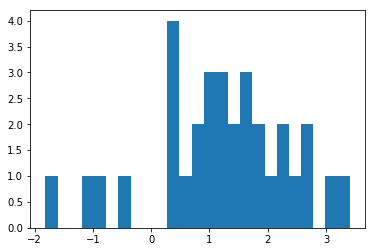

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



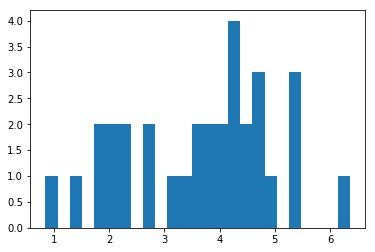

0.00925397872925
Training epoch 1000
Iter: 1000
D loss: 6.777
G_loss: 5.14
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.70535


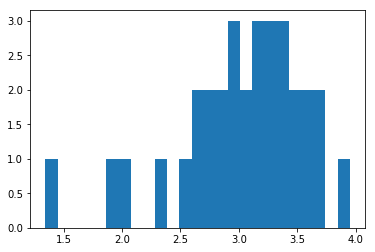

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



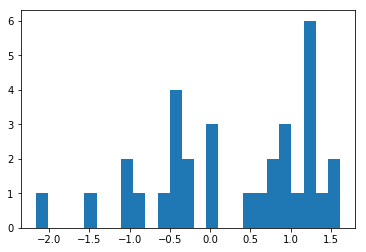

0.008465051651
Training epoch 2000
Iter: 2000
D loss: 6.496
G_loss: 5.142
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.00212


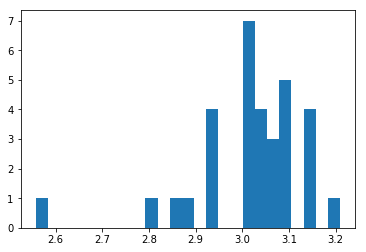

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



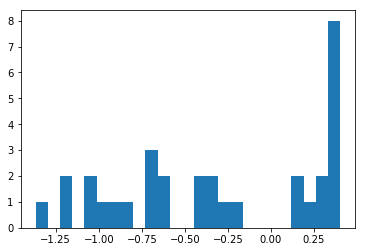

0.00858688354492
Training epoch 3000
Iter: 3000
D loss: 6.126
G_loss: 7.089
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.83713


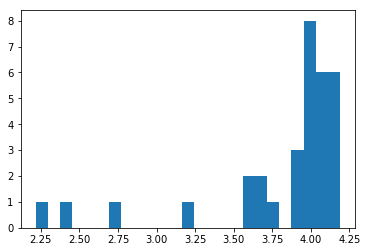

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



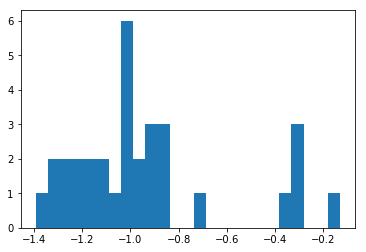

0.00880098342896
Training epoch 4000
Iter: 4000
D loss: 6.167
G_loss: 4.864
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.68705


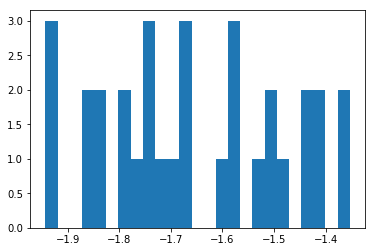

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



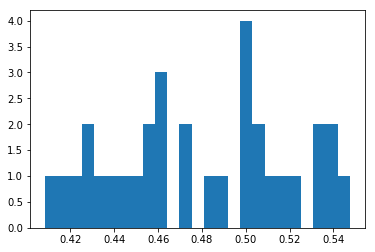

0.00858402252197
Training epoch 5000
Iter: 5000
D loss: 5.772
G_loss: 5.718
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.89203


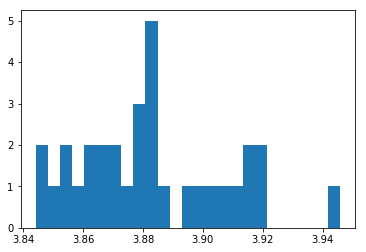

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



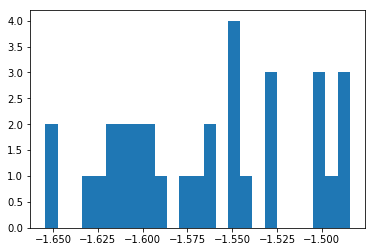

0.00865316390991
Training epoch 6000
Iter: 6000
D loss: 6.536
G_loss: 7.521
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.751619


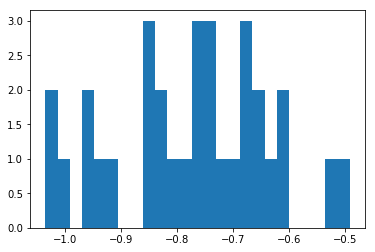

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



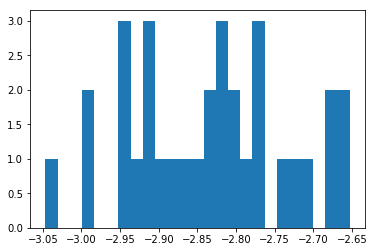

0.00819611549377
Training epoch 7000
Iter: 7000
D loss: 4.913
G_loss: 7.155
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.317228


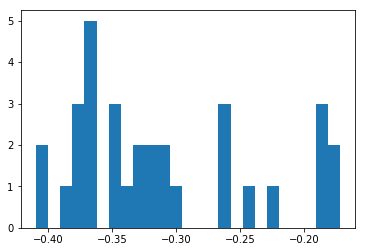

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



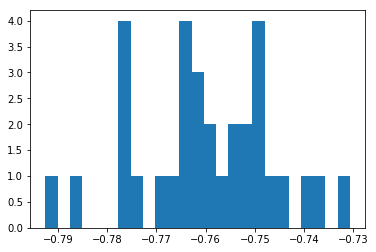

0.00832319259644
Training epoch 8000
Iter: 8000
D loss: 5.652
G_loss: 7.653
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.72454


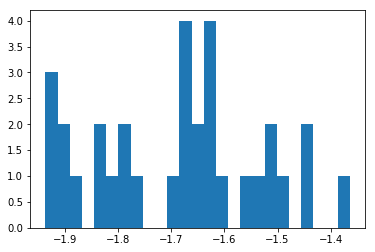

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



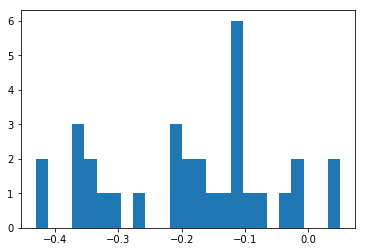

0.00867605209351
Training epoch 9000
Iter: 9000
D loss: 4.46
G_loss: 8.415
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.63696


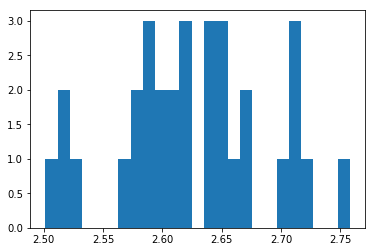

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



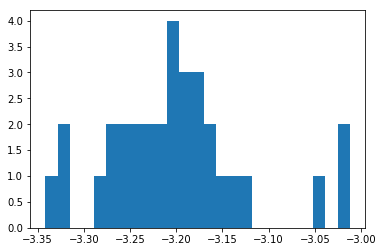

0.008455991745
Training epoch 10000
Iter: 10000
D loss: 3.479
G_loss: 10.42
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.523173


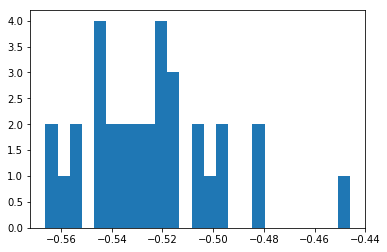

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



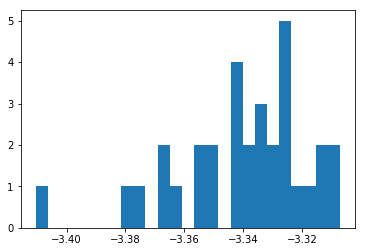

0.00868797302246
Training epoch 11000
Iter: 11000
D loss: 3.816
G_loss: 5.6
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.89796


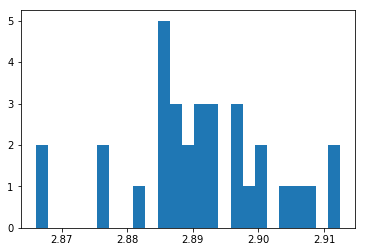

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



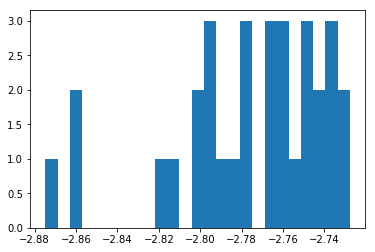

0.00811386108398
Training epoch 12000
Iter: 12000
D loss: 2.815
G_loss: 10.36
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.48719


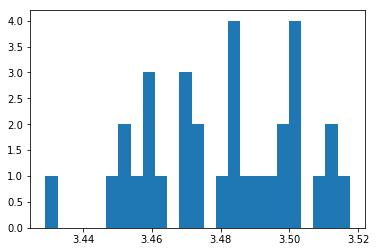

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



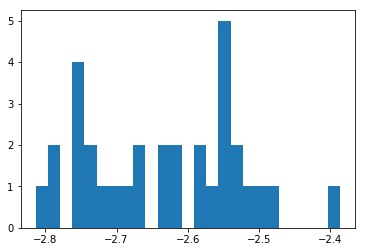

0.00847196578979
Training epoch 13000
Iter: 13000
D loss: 2.48
G_loss: 12.05
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.96101


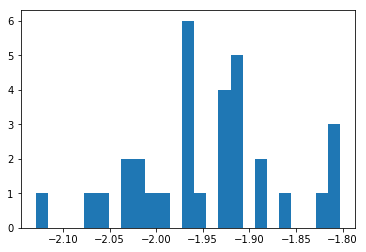

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



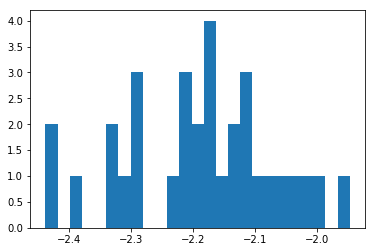

0.00859093666077
Training epoch 14000
Iter: 14000
D loss: 3.079
G_loss: 11.42
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.3331


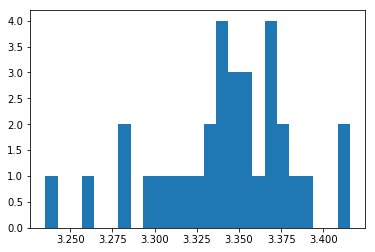

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



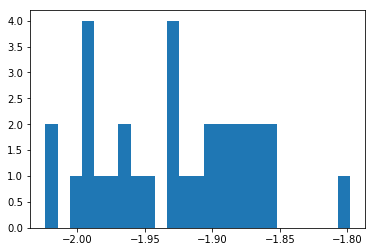

0.00844693183899
Training epoch 15000
Iter: 15000
D loss: 3.093
G_loss: 7.206
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.32371


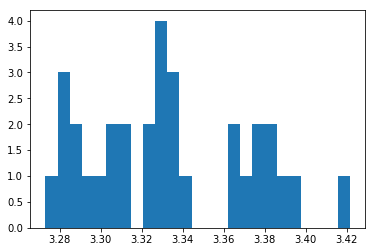

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



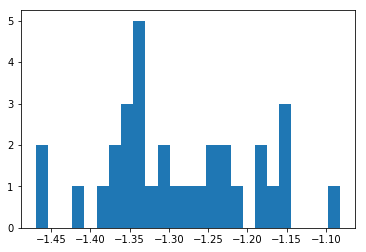

0.00835204124451
Training epoch 16000
Iter: 16000
D loss: 1.486
G_loss: 13.1
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.23057


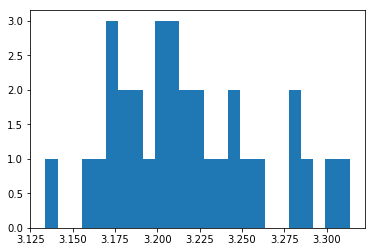

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



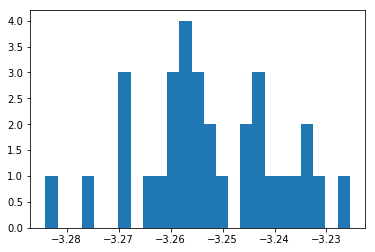

0.00838494300842
Training epoch 17000
Iter: 17000
D loss: 2.702
G_loss: 11.17
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.50546


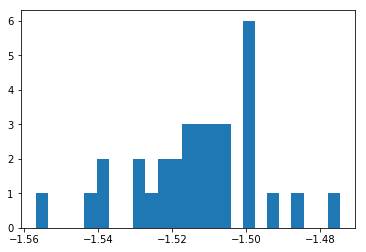

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



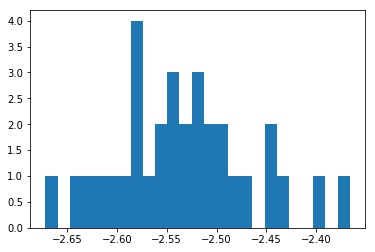

0.00829291343689
Training epoch 18000
Iter: 18000
D loss: 1.792
G_loss: 11.5
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.13265


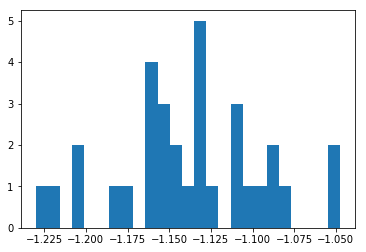

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



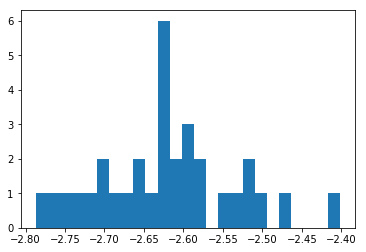

0.00818705558777
Training epoch 19000
Iter: 19000
D loss: 0.8031
G_loss: 13.54
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.963166


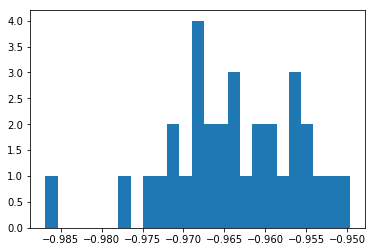

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



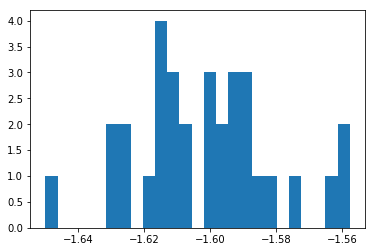

0.00842595100403
Training epoch 20000
Iter: 20000
D loss: 0.8033
G_loss: 13.26
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.06258


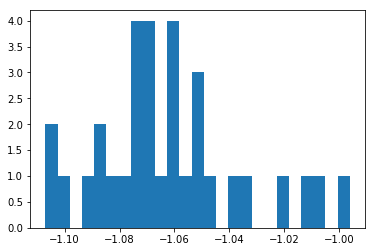

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



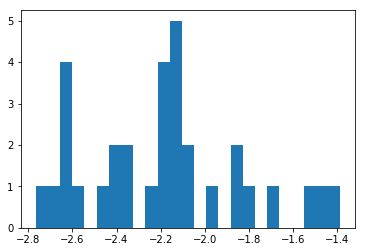

0.0082950592041
Training epoch 21000
Iter: 21000
D loss: 0.7154
G_loss: 13.49
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.27088


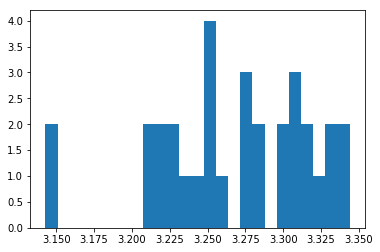

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



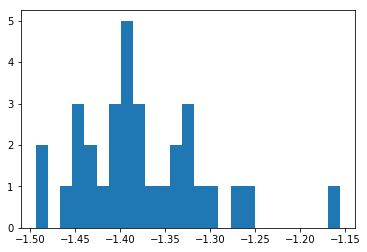

0.00836491584778
Training epoch 22000
Iter: 22000
D loss: 0.3995
G_loss: 14.09
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.47176


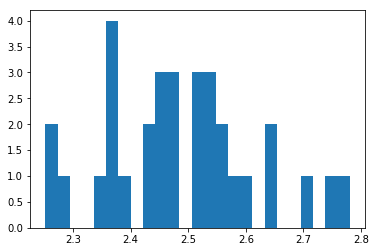

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



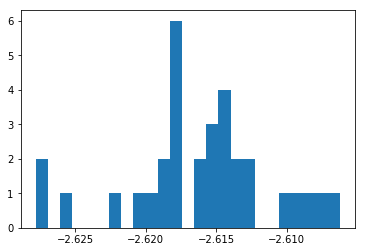

0.00873112678528
Training epoch 23000
Iter: 23000
D loss: 0.446
G_loss: 14.19
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.936315


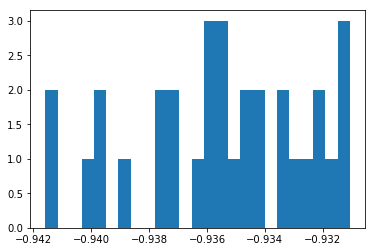

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



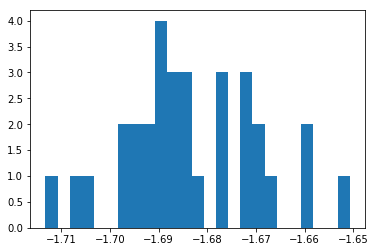

0.00847506523132
Training epoch 24000
Iter: 24000
D loss: 0.6273
G_loss: 14.27
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
4.40022


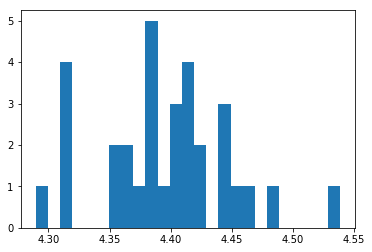

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



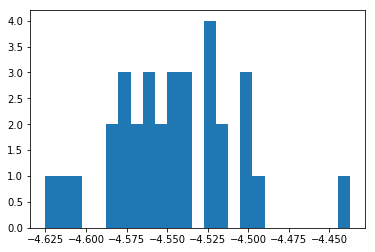

0.00838685035706
Training epoch 25000
Iter: 25000
D loss: 0.4854
G_loss: 14.25
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.31329


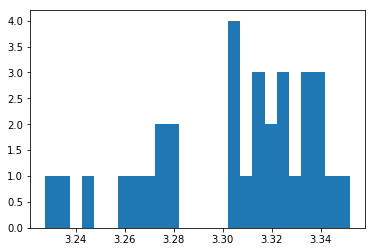

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



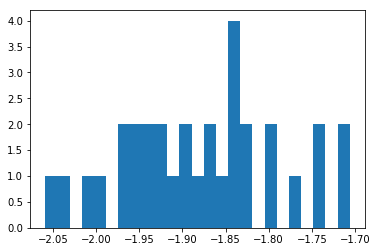

0.0084080696106
Training epoch 26000
Iter: 26000
D loss: 0.3788
G_loss: 14.41
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.14284


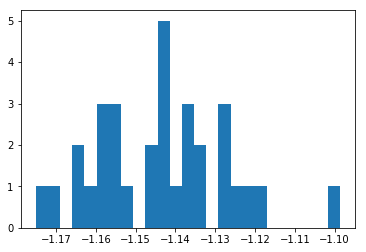

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



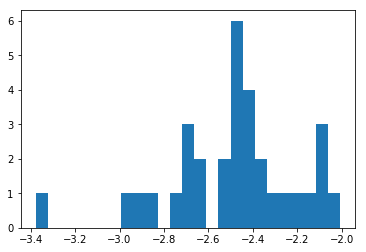

0.00873398780823
Training epoch 27000
Iter: 27000
D loss: 0.6841
G_loss: 13.94
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-3.19073


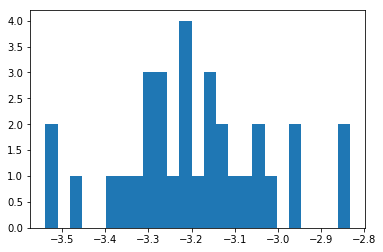

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



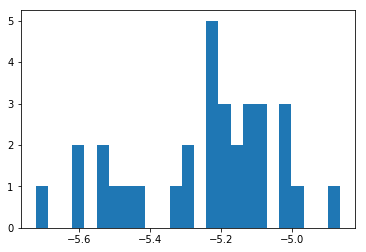

0.00832986831665
Training epoch 28000
Iter: 28000
D loss: 1.064
G_loss: 13.57
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.922919


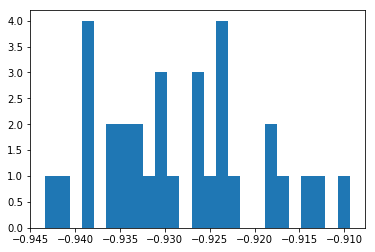

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



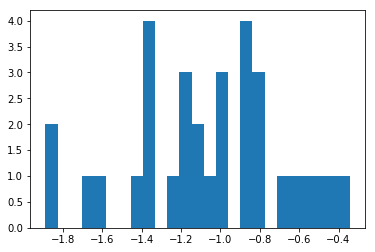

0.00887703895569
Training epoch 29000
Iter: 29000
D loss: 0.5569
G_loss: 14.43
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.831651


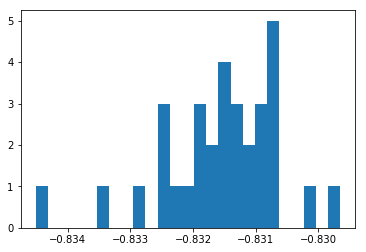

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



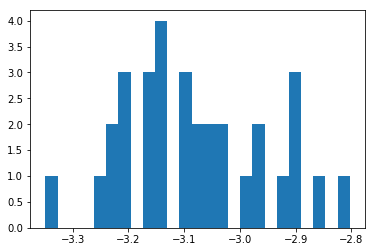

0.00814914703369
Training epoch 30000
Iter: 30000
D loss: 4.595
G_loss: 12.58
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.95366


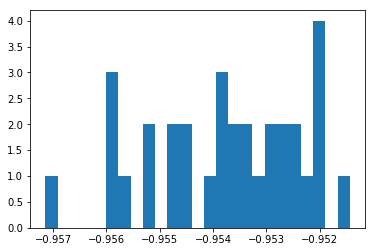

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



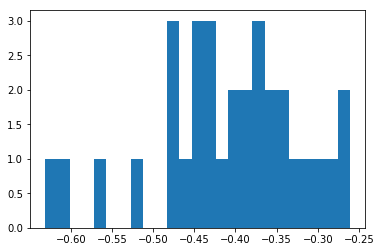

0.00833201408386
Training epoch 31000
Iter: 31000
D loss: 4.123
G_loss: 12.62
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.20961


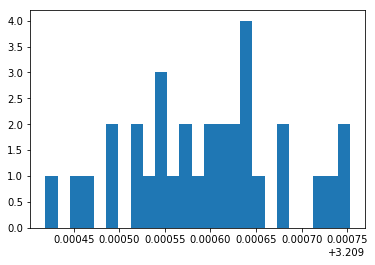

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



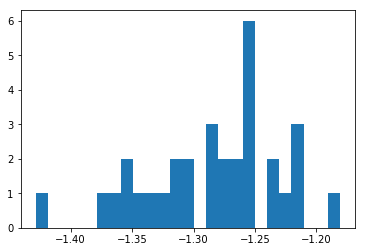

0.00854301452637
Training epoch 32000
Iter: 32000
D loss: 0.5953
G_loss: 15.19
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.3045


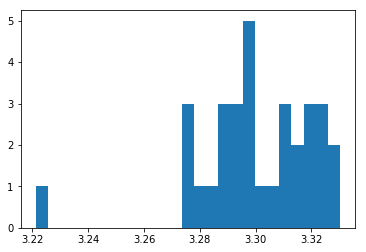

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



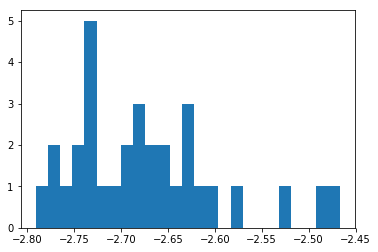

0.00852799415588
Training epoch 33000
Iter: 33000
D loss: 0.6613
G_loss: 14.01
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.07663


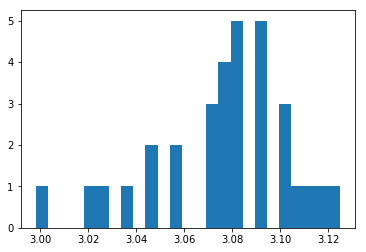

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



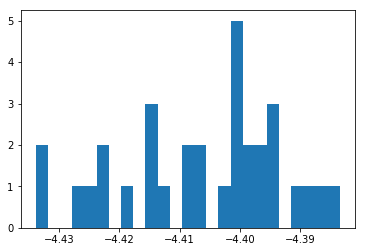

0.00879502296448
Training epoch 34000
Iter: 34000
D loss: 0.5679
G_loss: 14.05
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.27646


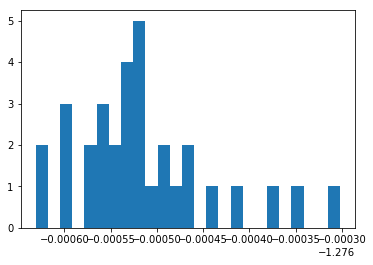

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



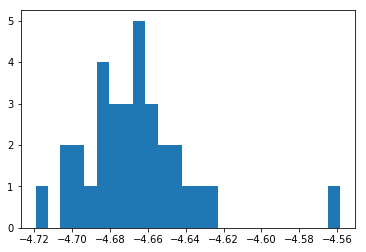

0.00857496261597
Training epoch 35000
Iter: 35000
D loss: 0.2956
G_loss: 14.46
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.99695


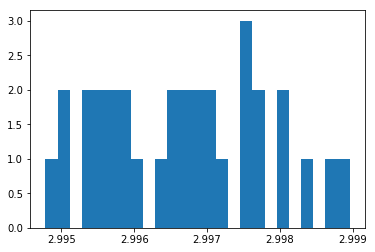

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



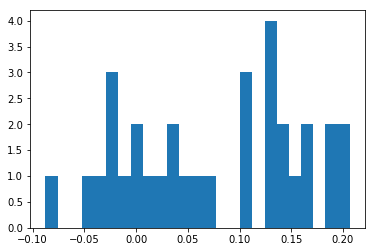

0.0081729888916
Training epoch 36000
Iter: 36000
D loss: 0.3128
G_loss: 14.64
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.0979


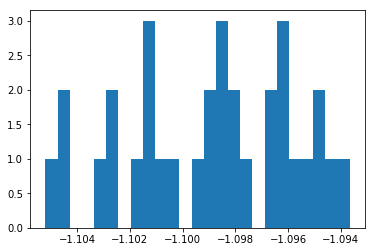

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



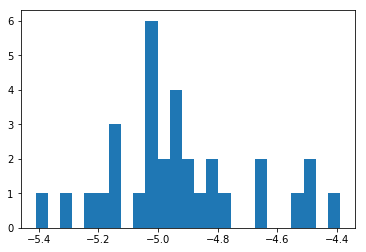

0.0083019733429
Training epoch 37000
Iter: 37000
D loss: 0.837
G_loss: 14.38
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.20158


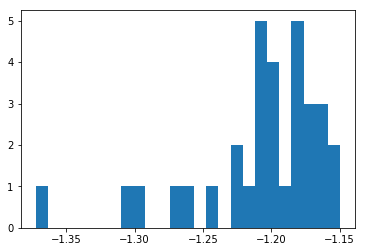

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



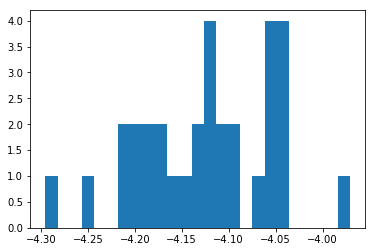

0.00824904441833
Training epoch 38000
Iter: 38000
D loss: 0.2252
G_loss: 15.05
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.24513


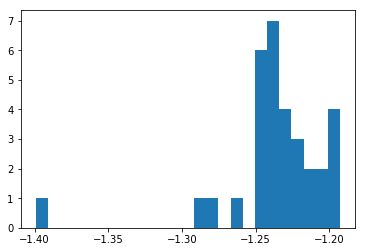

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



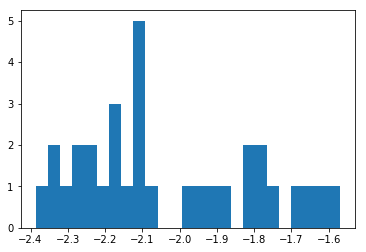

0.00825309753418
Training epoch 39000
Iter: 39000
D loss: 0.5409
G_loss: 14.42
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.20483


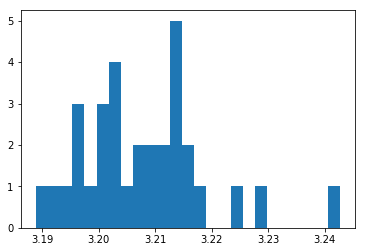

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



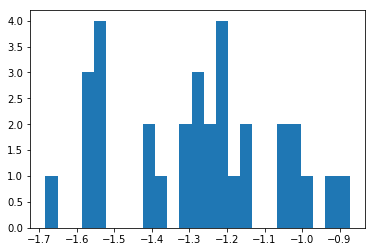

0.00844597816467
Training epoch 40000
Iter: 40000
D loss: 0.3429
G_loss: 14.9
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.03177


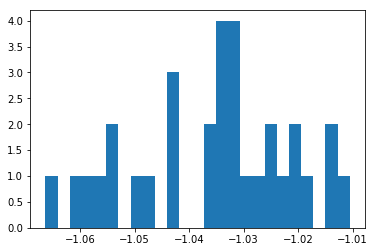

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



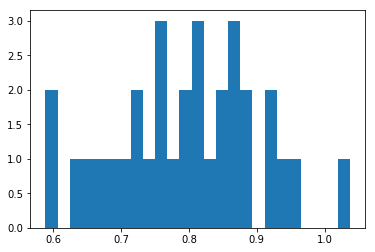

0.00854015350342
Training epoch 41000
Iter: 41000
D loss: 0.1792
G_loss: 15.48
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.826657


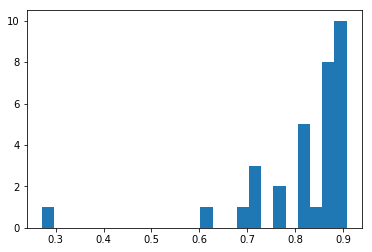

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



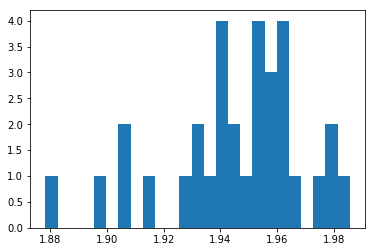

0.0083909034729
Training epoch 42000
Iter: 42000
D loss: 0.7599
G_loss: 14.84
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.01892


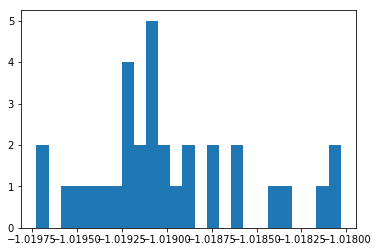

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



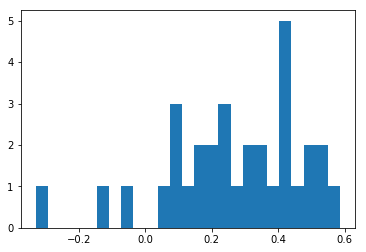

0.00826787948608
Training epoch 43000
Iter: 43000
D loss: 0.1476
G_loss: 15.12
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.05684


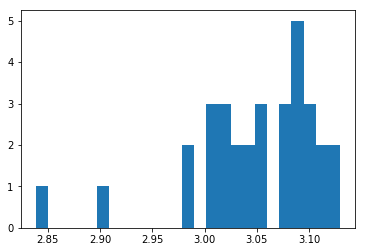

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



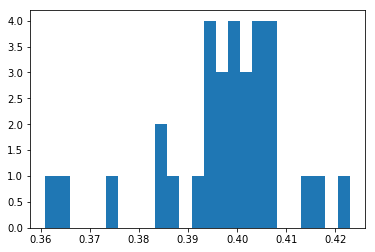

0.00855684280396
Training epoch 44000
Iter: 44000
D loss: 0.4188
G_loss: 14.93
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.93238


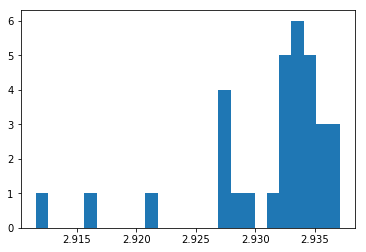

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



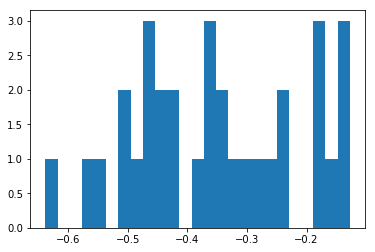

0.00829601287842
Training epoch 45000
Iter: 45000
D loss: 0.8417
G_loss: 14.67
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.57758


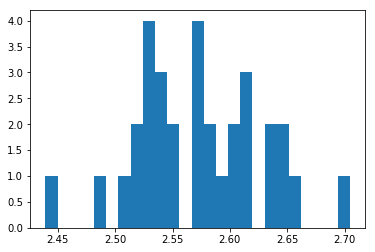

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



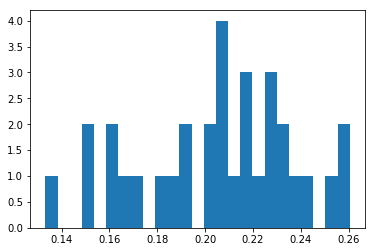

0.00871992111206
Training epoch 46000
Iter: 46000
D loss: 0.3378
G_loss: 15.09
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.8555


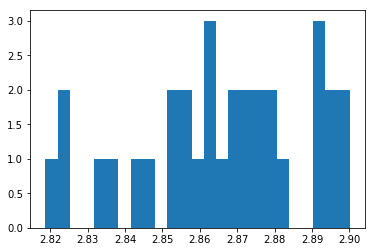

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



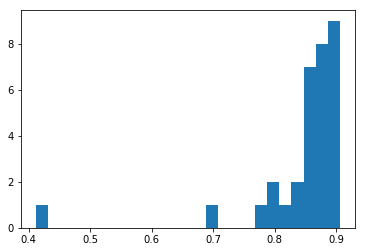

0.00883197784424
Training epoch 47000
Iter: 47000
D loss: 3.369
G_loss: 9.104
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.1699


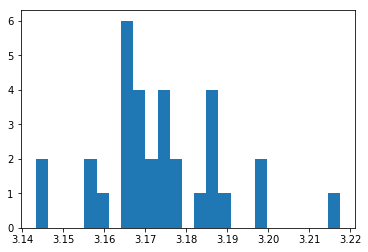

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



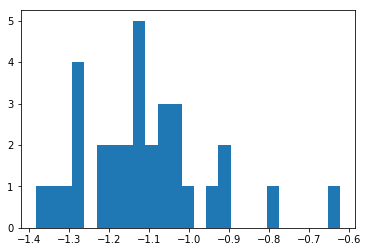

0.00840497016907
Training epoch 48000
Iter: 48000
D loss: 0.3065
G_loss: 15.05
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.01475


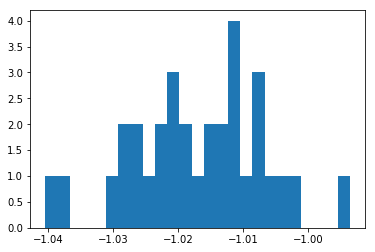

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



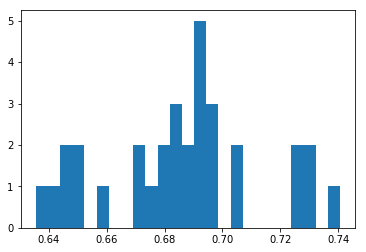

0.00835680961609
Training epoch 49000
Iter: 49000
D loss: 0.4322
G_loss: 14.67
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.05498


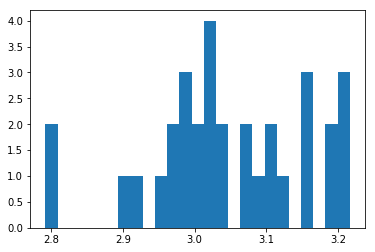

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



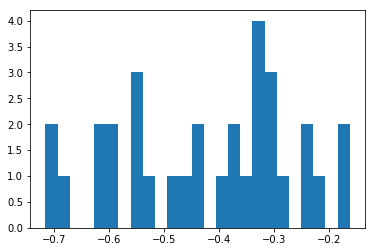

0.00871801376343
Training epoch 50000
Iter: 50000
D loss: 0.3608
G_loss: 15.09
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.85594


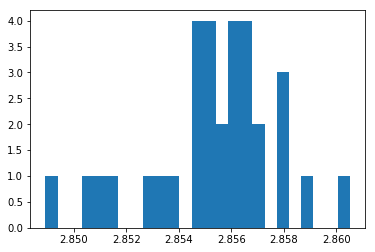

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



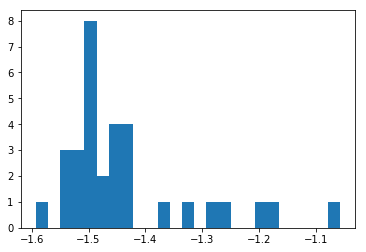

0.0082528591156
Training epoch 51000
Iter: 51000
D loss: 0.8584
G_loss: 15.09
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.01199


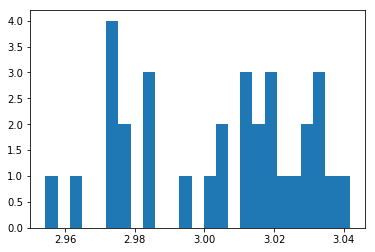

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



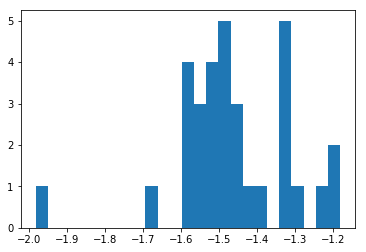

0.00937294960022
Training epoch 52000
Iter: 52000
D loss: 0.7473
G_loss: 15.0
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.70947


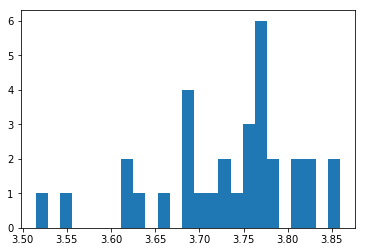

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



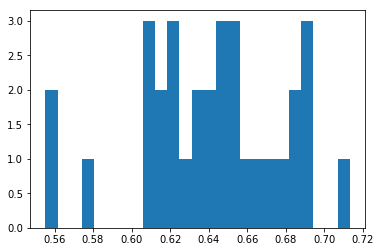

0.00965404510498
Training epoch 53000
Iter: 53000
D loss: 0.1925
G_loss: 15.14
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.680864


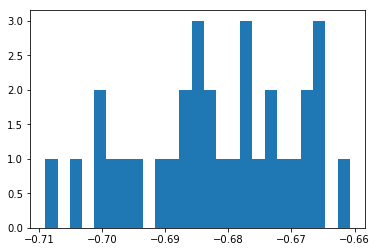

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



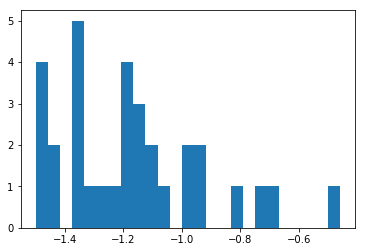

0.00976014137268
Training epoch 54000
Iter: 54000
D loss: 0.2344
G_loss: 15.07
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.25113


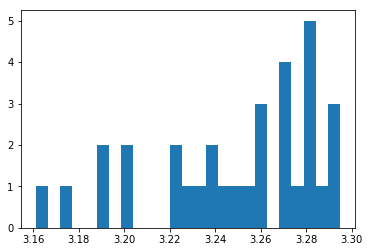

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



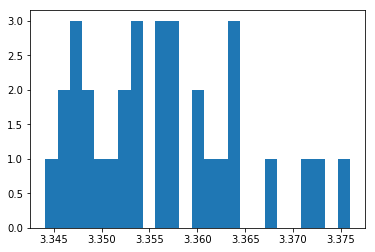

0.0097439289093
Training epoch 55000
Iter: 55000
D loss: 0.392
G_loss: 14.42
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.93642


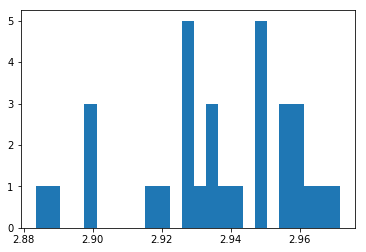

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



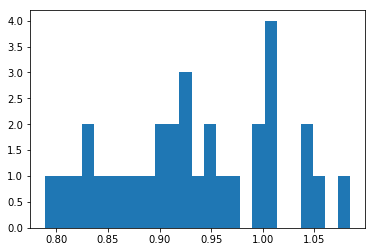

0.00985312461853
Training epoch 56000
Iter: 56000
D loss: 0.1905
G_loss: 15.02
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.08752


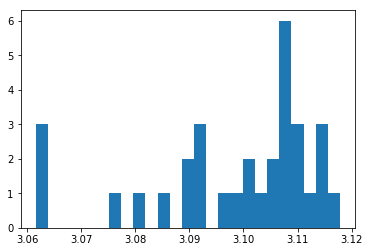

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



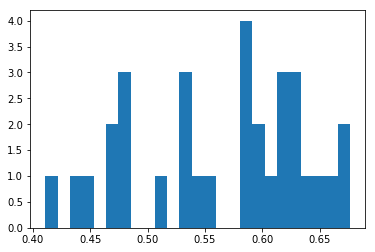

0.0097599029541
Training epoch 57000
Iter: 57000
D loss: 0.8397
G_loss: 15.03
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.16024


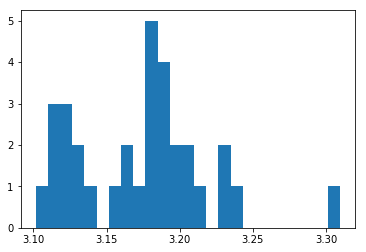

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



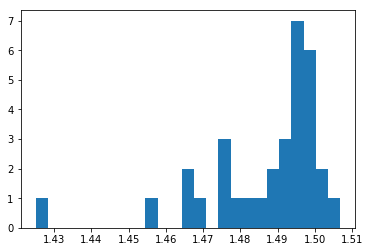

0.0100209712982
Training epoch 58000
Iter: 58000
D loss: 0.1068
G_loss: 14.87
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.00131


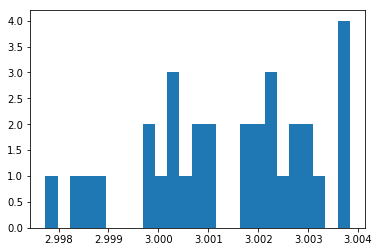

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



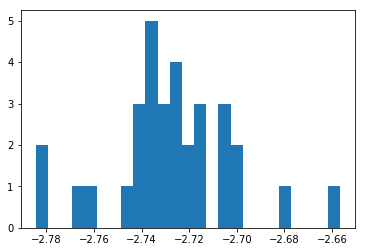

0.0098729133606
Training epoch 59000
Iter: 59000
D loss: 0.4543
G_loss: 14.9
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
5.80084


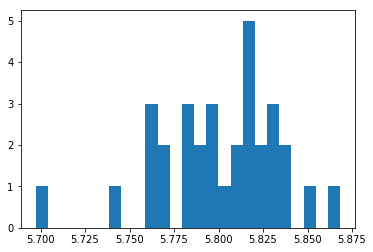

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



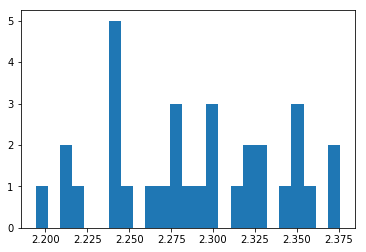

0.00976991653442
Training epoch 60000
Iter: 60000
D loss: 0.1704
G_loss: 15.22
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.17576


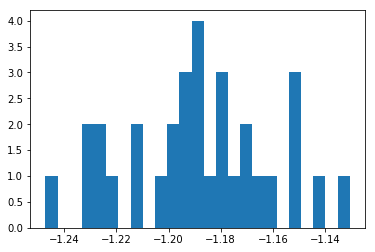

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



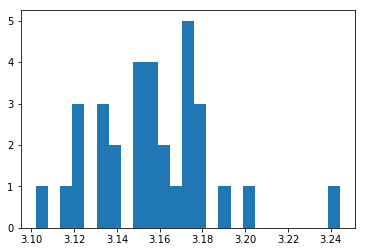

0.00951504707336
Training epoch 61000
Iter: 61000
D loss: 0.06489
G_loss: 15.44
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.917015


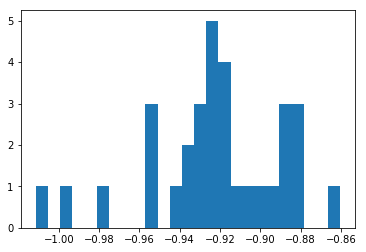

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



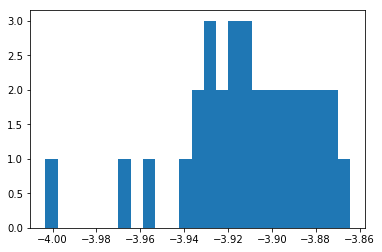

0.00945019721985
Training epoch 62000
Iter: 62000
D loss: 0.1636
G_loss: 15.18
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.29448


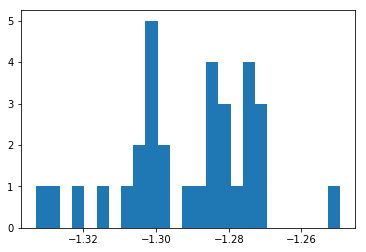

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



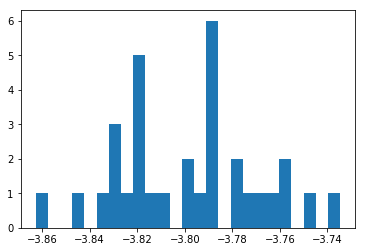

0.00983190536499
Training epoch 63000
Iter: 63000
D loss: 0.2536
G_loss: 15.1
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-3.78722


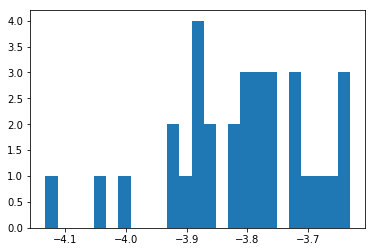

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



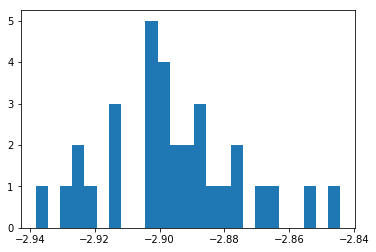

0.00943613052368
Training epoch 64000
Iter: 64000
D loss: 0.0963
G_loss: 15.27
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-5.29818


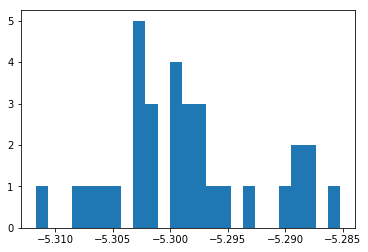

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



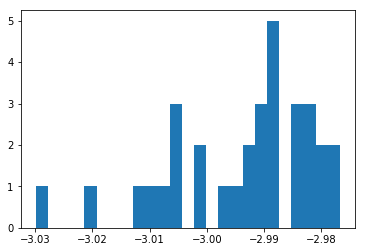

0.00977611541748
Training epoch 65000
Iter: 65000
D loss: 0.05172
G_loss: 15.55
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-5.17697


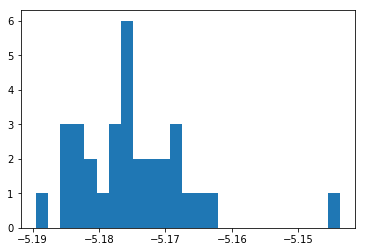

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



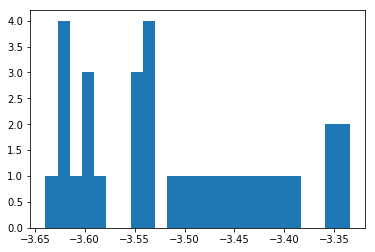

0.00955009460449
Training epoch 66000
Iter: 66000
D loss: 0.0337
G_loss: 15.56
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.397999


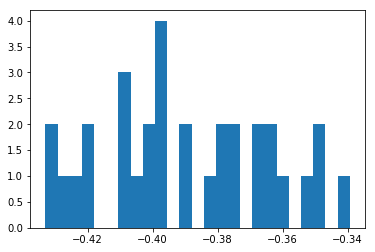

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



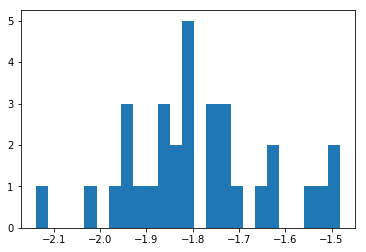

0.00960493087769
Training epoch 67000
Iter: 67000
D loss: 0.02774
G_loss: 15.73
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.33137


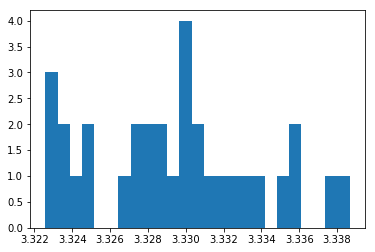

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



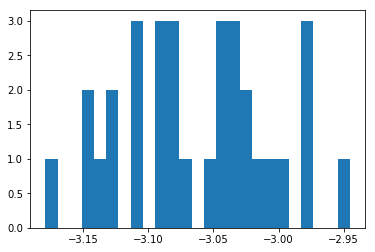

0.00962495803833
Training epoch 68000
Iter: 68000
D loss: 0.1158
G_loss: 15.16
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.2934


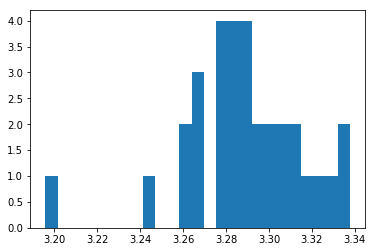

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



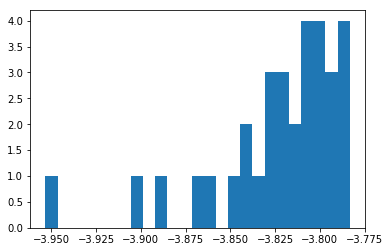

0.00967907905579
Training epoch 69000
Iter: 69000
D loss: 0.4507
G_loss: 15.45
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.233213


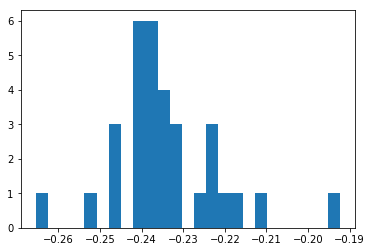

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



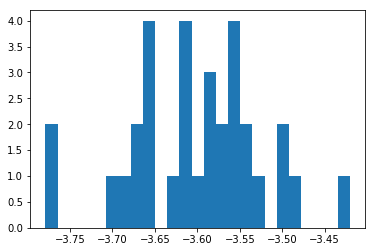

0.00982904434204
Training epoch 70000
Iter: 70000
D loss: 0.06253
G_loss: 15.42
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.662264


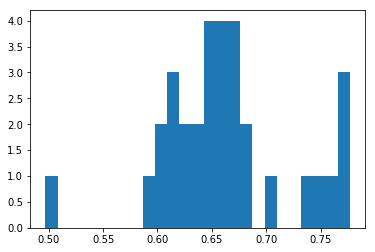

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



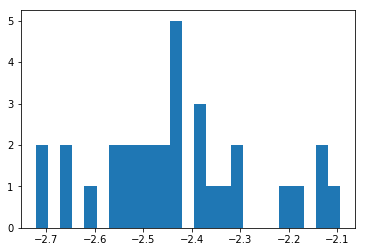

0.00940299034119
Training epoch 71000
Iter: 71000
D loss: 0.07097
G_loss: 15.59
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.18649


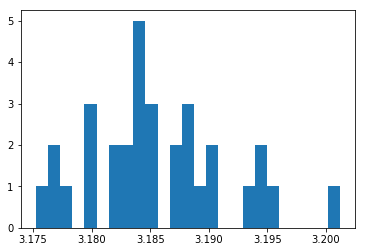

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



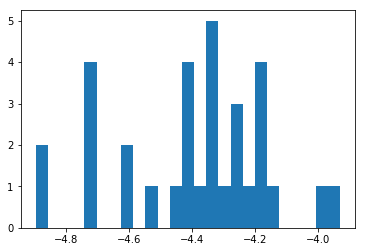

0.0096709728241
Training epoch 72000
Iter: 72000
D loss: 0.04787
G_loss: 15.66
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.89376


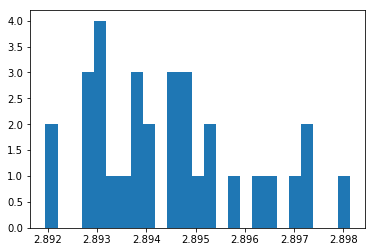

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



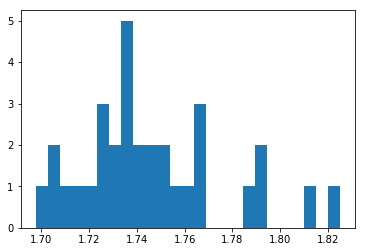

0.00965023040771
Training epoch 73000
Iter: 73000
D loss: 0.0142
G_loss: 15.72
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.30624


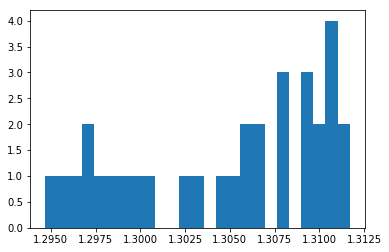

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



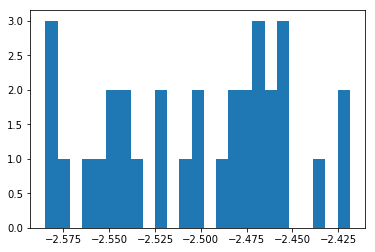

0.009840965271
Training epoch 74000
Iter: 74000
D loss: 0.01827
G_loss: 15.78
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.14441


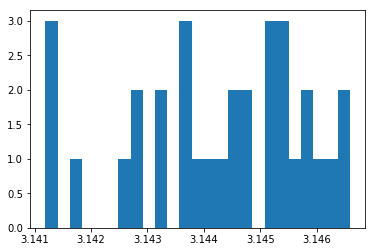

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



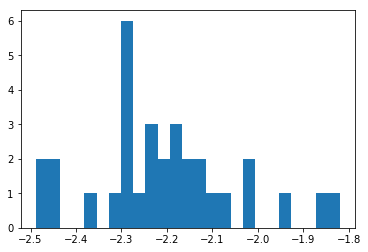

0.00966691970825
Training epoch 75000
Iter: 75000
D loss: 0.06888
G_loss: 15.54
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.0398


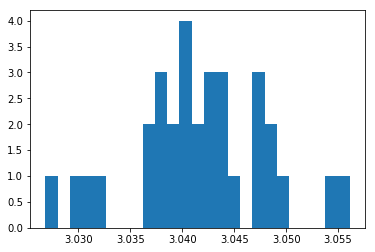

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



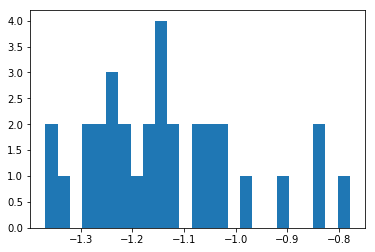

0.0097029209137
Training epoch 76000
Iter: 76000
D loss: 0.1772
G_loss: 15.35
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.46415


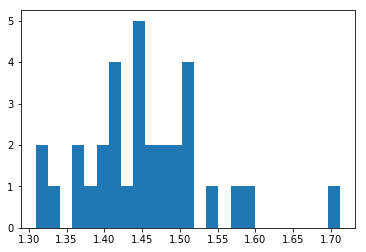

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



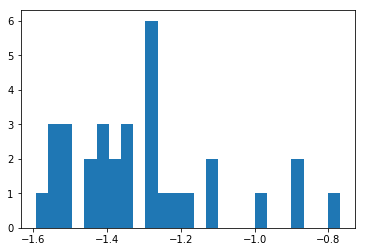

0.00987601280212
Training epoch 77000
Iter: 77000
D loss: 0.1009
G_loss: 15.55
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.911348


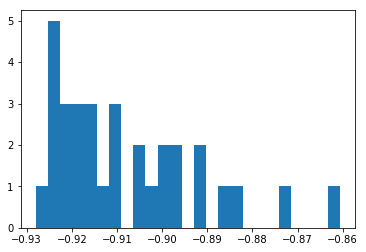

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



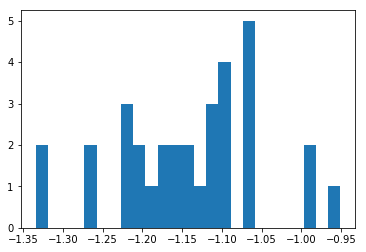

0.00946521759033
Training epoch 78000
Iter: 78000
D loss: 0.06012
G_loss: 15.5
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.1552


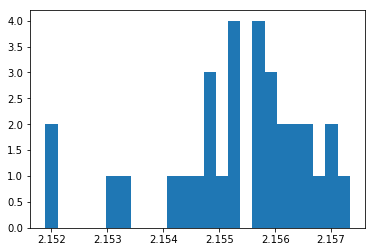

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



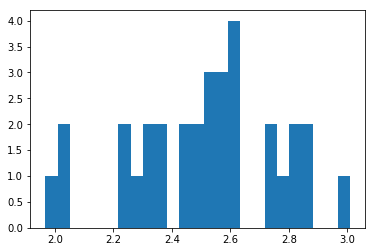

0.00936198234558
Training epoch 79000
Iter: 79000
D loss: 0.05456
G_loss: 15.51
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.07534


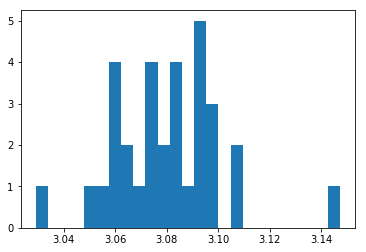

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



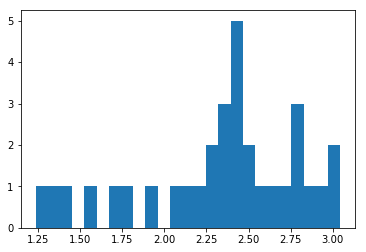

0.00960397720337
Training epoch 80000
Iter: 80000
D loss: 0.05186
G_loss: 15.64
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.01068


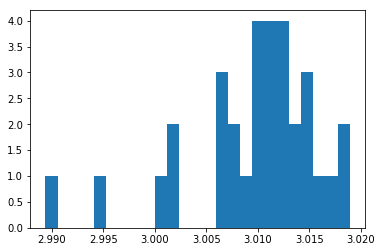

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



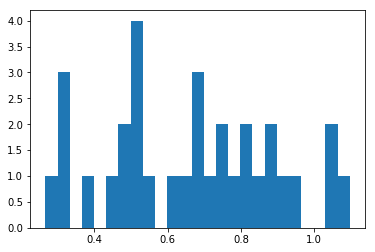

0.00987315177917
Training epoch 81000
Iter: 81000
D loss: 0.03543
G_loss: 15.65
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.84506


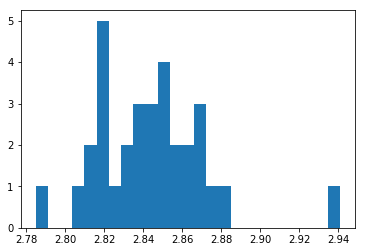

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



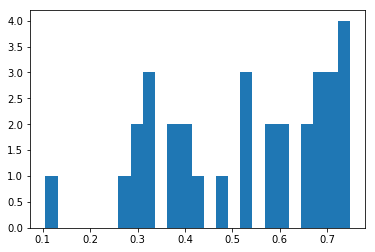

0.00975394248962
Training epoch 82000
Iter: 82000
D loss: 0.05278
G_loss: 15.5
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.93608


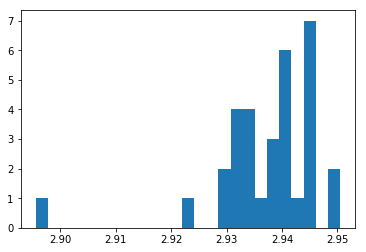

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



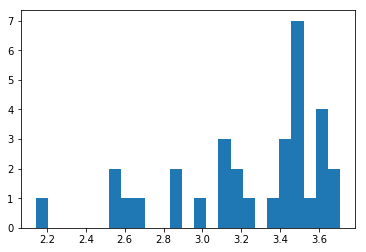

0.00930595397949
Training epoch 83000
Iter: 83000
D loss: 0.4563
G_loss: 15.02
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.2937


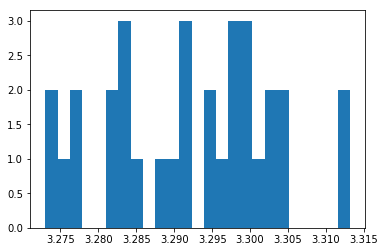

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



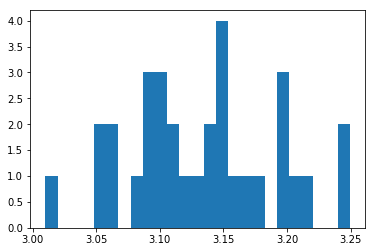

0.00945401191711
Training epoch 84000
Iter: 84000
D loss: 0.1856
G_loss: 15.47
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.07812


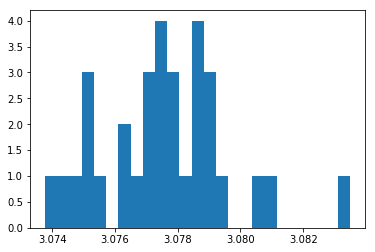

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



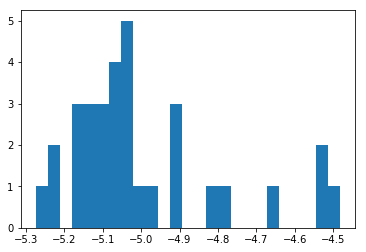

0.00964713096619
Training epoch 85000
Iter: 85000
D loss: 0.06898
G_loss: 15.63
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.13622


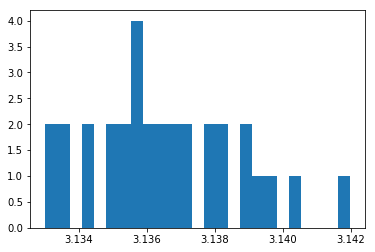

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



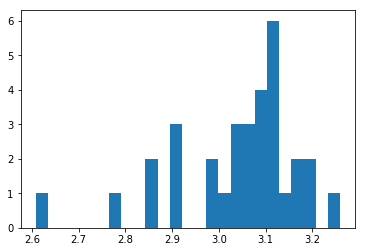

0.0096321105957
Training epoch 86000
Iter: 86000
D loss: 0.06527
G_loss: 15.45
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.43248


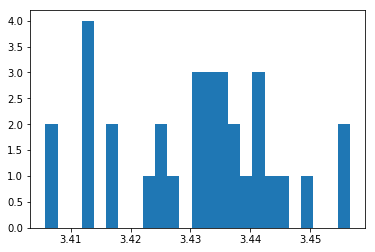

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



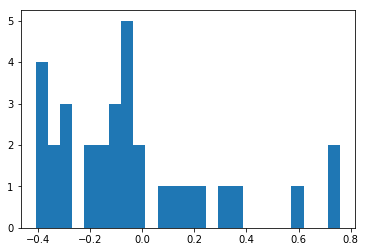

0.00978088378906
Training epoch 87000
Iter: 87000
D loss: 0.3516
G_loss: 14.79
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.85123


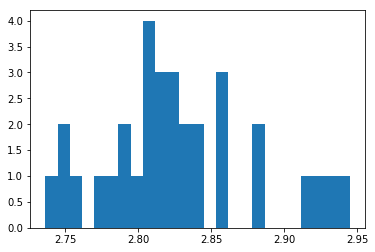

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



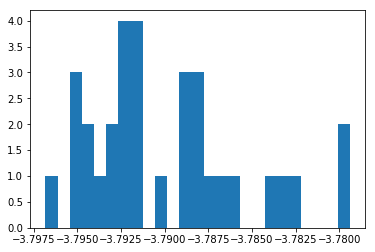

0.0095329284668
Training epoch 88000
Iter: 88000
D loss: 0.05776
G_loss: 15.58
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.02569


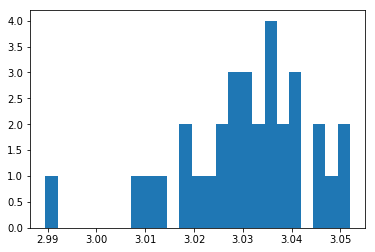

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



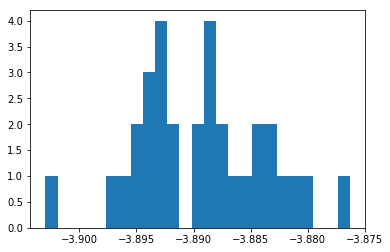

0.00936102867126
Training epoch 89000
Iter: 89000
D loss: 0.08734
G_loss: 15.18
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.07062


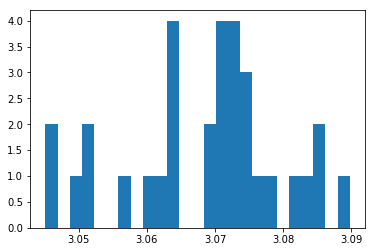

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



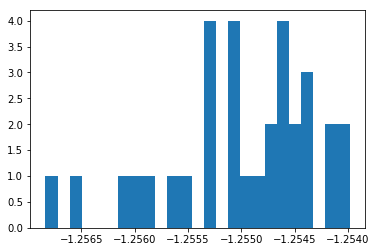

0.00959277153015
Training epoch 90000
Iter: 90000
D loss: 0.07176
G_loss: 15.5
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.10578


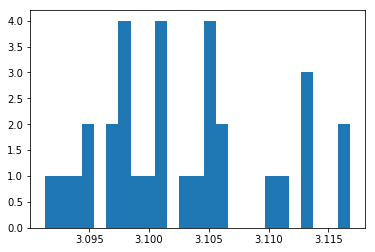

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



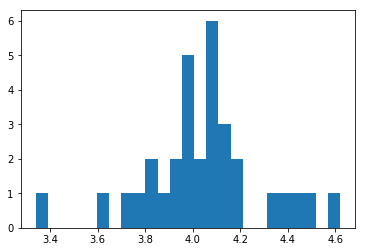

0.00946593284607
Training epoch 91000
Iter: 91000
D loss: 0.1852
G_loss: 15.88
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.91839


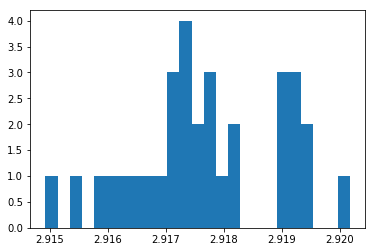

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



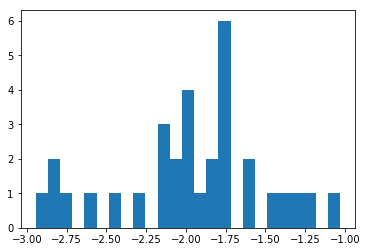

0.00929689407349
Training epoch 92000
Iter: 92000
D loss: 0.03568
G_loss: 15.52
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.2765


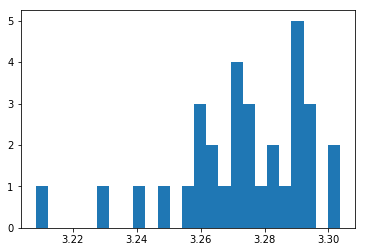

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



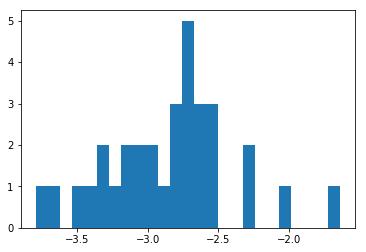

0.00967597961426
Training epoch 93000
Iter: 93000
D loss: 0.04584
G_loss: 15.6
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.940361


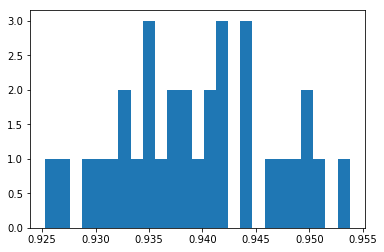

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



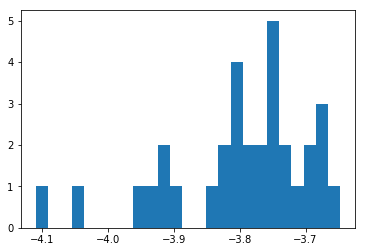

0.00977802276611
Training epoch 94000
Iter: 94000
D loss: 0.0405
G_loss: 15.7
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.33088


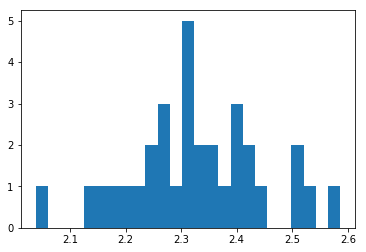

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



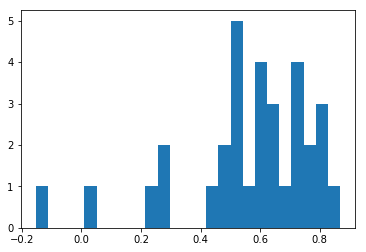

0.00959706306458
Training epoch 95000
Iter: 95000
D loss: 0.126
G_loss: 15.34
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
4.91047


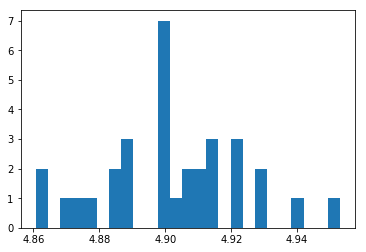

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



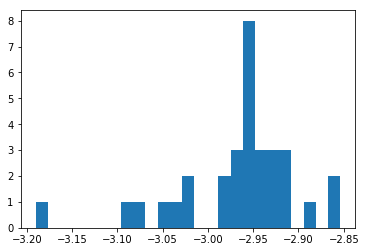

0.00961804389954
Training epoch 96000
Iter: 96000
D loss: 0.2062
G_loss: 15.41
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
5.58399


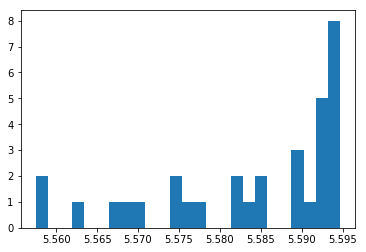

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



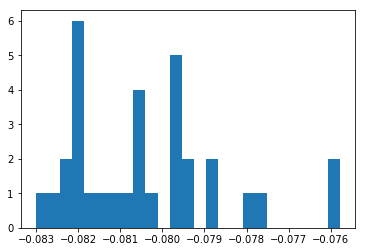

0.00959610939026
Training epoch 97000
Iter: 97000
D loss: 0.2652
G_loss: 15.79
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.677433


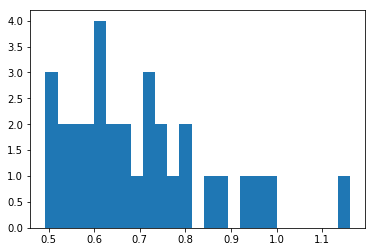

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



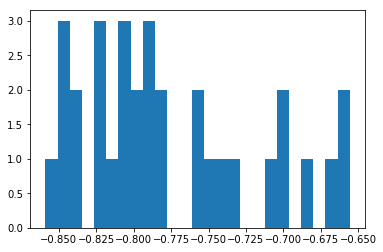

0.00970697402954
Training epoch 98000
Iter: 98000
D loss: 0.1839
G_loss: 15.38
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.87217


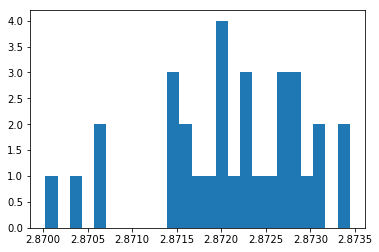

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



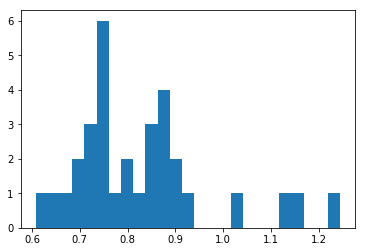

0.00962400436401
Training epoch 99000
Iter: 99000
D loss: 0.6229
G_loss: 15.46
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.19162


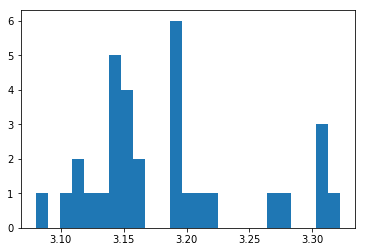

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



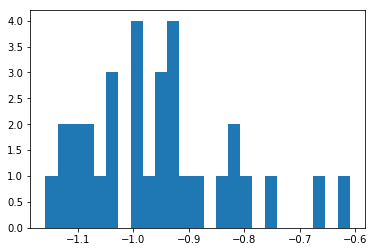

0.00921583175659
Training epoch 100000
Iter: 100000
D loss: 0.5481
G_loss: 15.6
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
7.01436


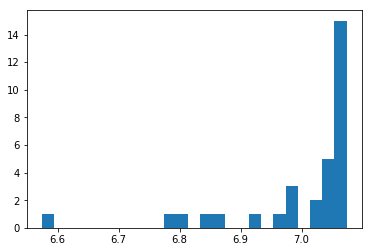

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



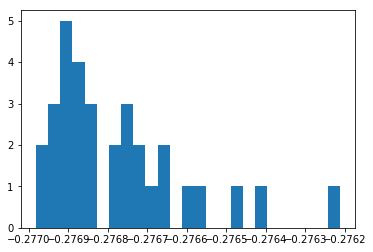

0.00946307182312
Training epoch 101000
Iter: 101000
D loss: 0.5918
G_loss: 15.56
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.731223


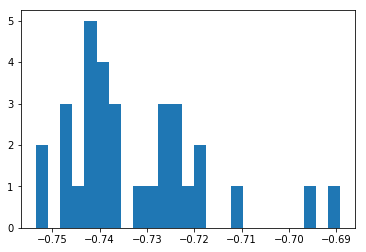

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



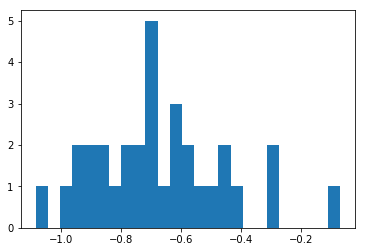

0.00981712341309
Training epoch 102000
Iter: 102000
D loss: 0.04855
G_loss: 15.75
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.21681


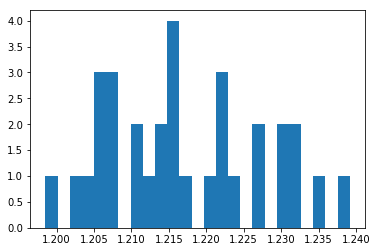

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



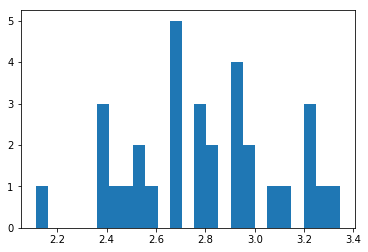

0.0095419883728
Training epoch 103000
Iter: 103000
D loss: 0.1089
G_loss: 15.4
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.80539


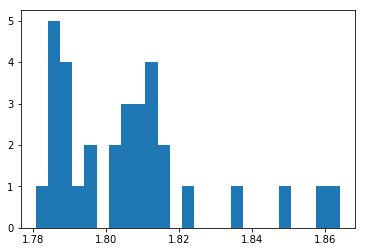

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



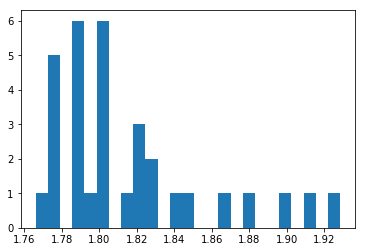

0.00930905342102
Training epoch 104000
Iter: 104000
D loss: 0.1732
G_loss: 15.42
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
6.91842


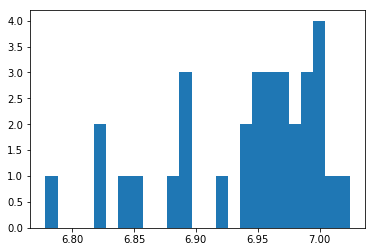

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



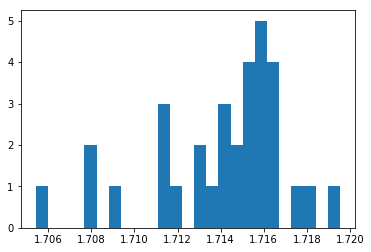

0.00928497314453
Training epoch 105000
Iter: 105000
D loss: 0.1262
G_loss: 15.41
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.71056


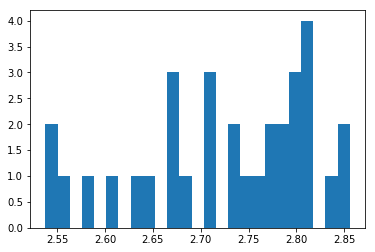

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



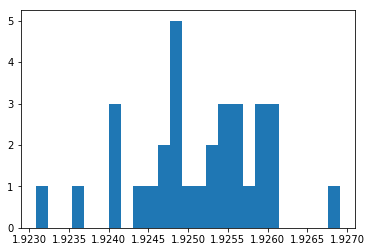

0.00953698158264
Training epoch 106000
Iter: 106000
D loss: 0.324
G_loss: 15.42
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.09063


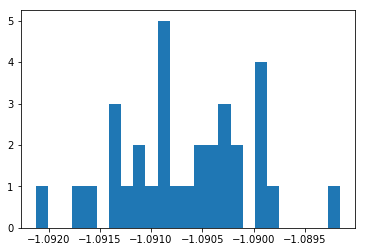

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



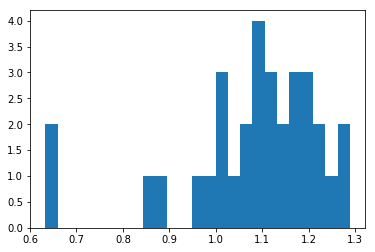

0.00919508934021
Training epoch 107000
Iter: 107000
D loss: 0.1431
G_loss: 15.3
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.75166


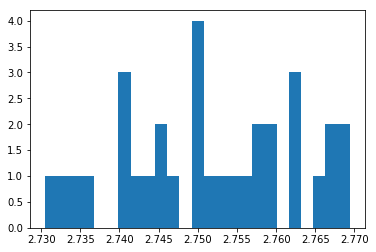

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



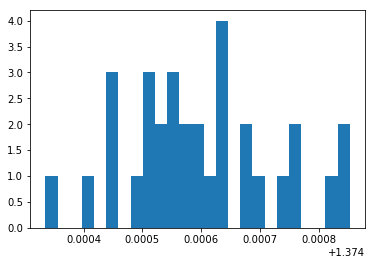

0.00975179672241
Training epoch 108000
Iter: 108000
D loss: 0.2158
G_loss: 15.6
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.20379


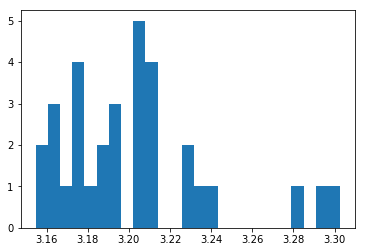

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



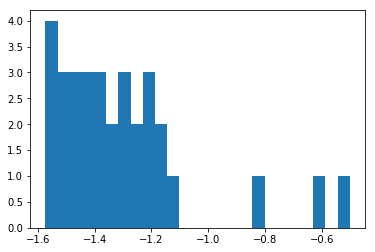

0.00950312614441
Training epoch 109000
Iter: 109000
D loss: 0.6205
G_loss: 14.31
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.58262


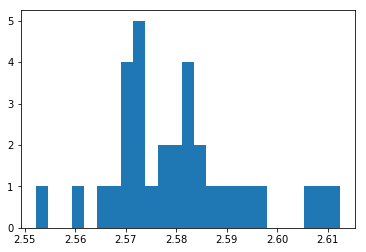

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



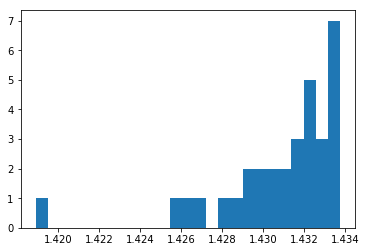

0.0108771324158
Training epoch 110000
Iter: 110000
D loss: 0.08585
G_loss: 15.53
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.62027


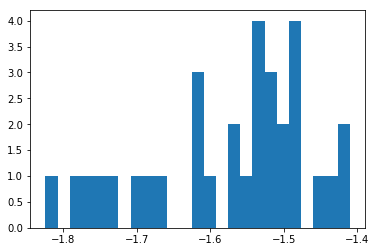

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



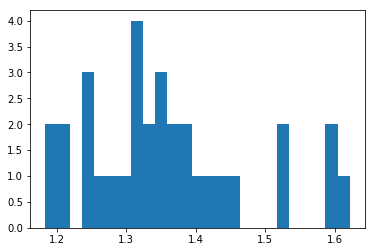

0.00944590568542
Training epoch 111000
Iter: 111000
D loss: 0.09558
G_loss: 15.49
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.622218


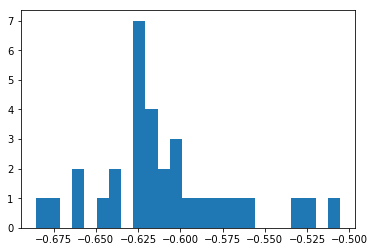

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



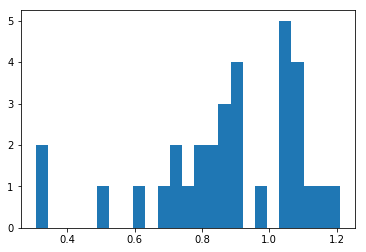

0.00937294960022
Training epoch 112000
Iter: 112000
D loss: 0.04359
G_loss: 15.64
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.82662


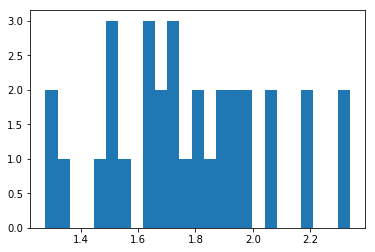

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



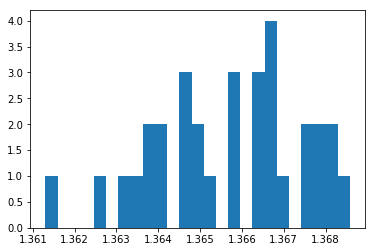

0.00963282585144
Training epoch 113000
Iter: 113000
D loss: 0.9067
G_loss: 15.01
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.939097


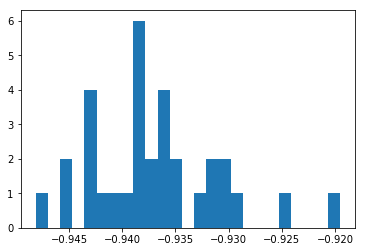

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



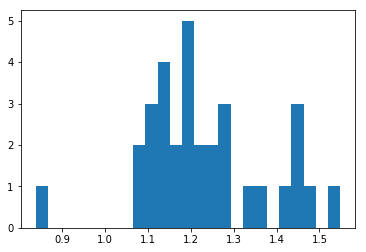

0.00945687294006
Training epoch 114000
Iter: 114000
D loss: 0.09196
G_loss: 15.52
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.783574


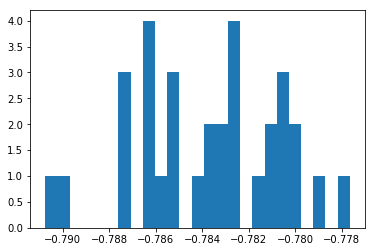

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



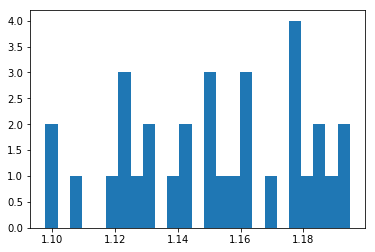

0.00963306427002
Training epoch 115000
Iter: 115000
D loss: 0.2463
G_loss: 15.25
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.615375


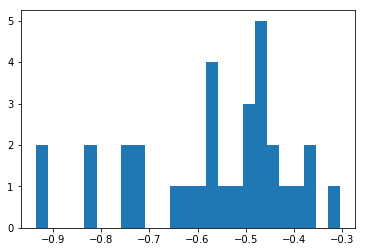

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



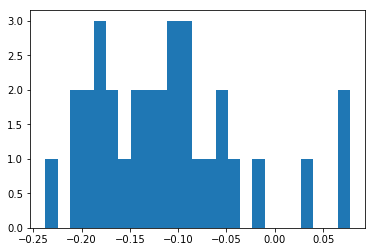

0.0095808506012
Training epoch 116000
Iter: 116000
D loss: 0.07593
G_loss: 15.48
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.01124


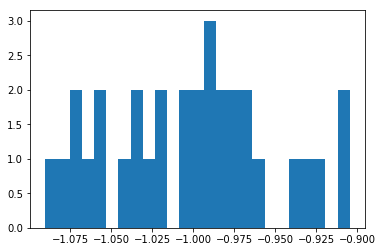

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



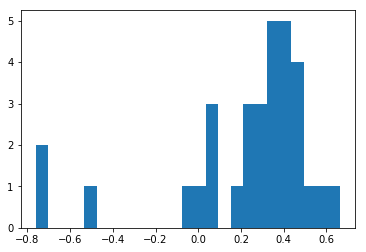

0.00913500785828
Training epoch 117000
Iter: 117000
D loss: 0.1255
G_loss: 15.5
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.31741


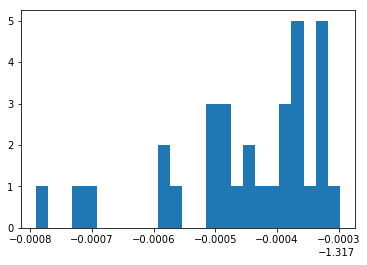

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



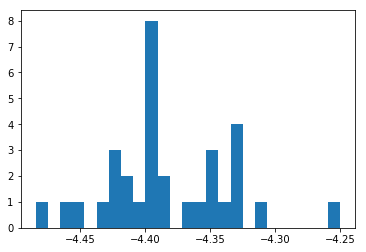

0.00960206985474
Training epoch 118000
Iter: 118000
D loss: 0.1696
G_loss: 15.67
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.238943


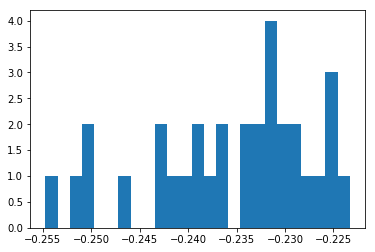

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



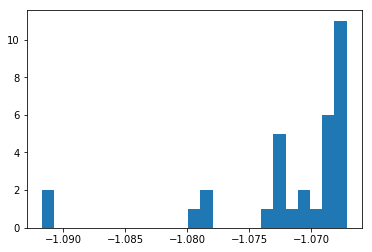

0.00964689254761
Training epoch 119000
Iter: 119000
D loss: 0.1051
G_loss: 15.5
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.27484


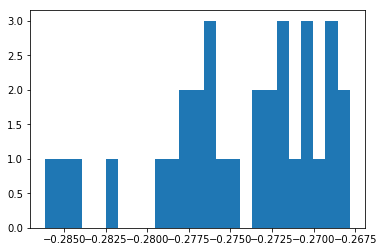

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



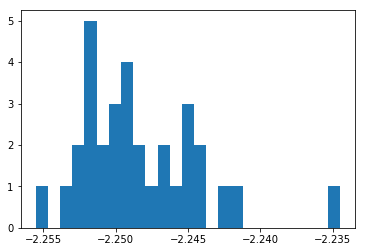

0.0093240737915
Training epoch 120000
Iter: 120000
D loss: 0.07974
G_loss: 15.56
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.42244


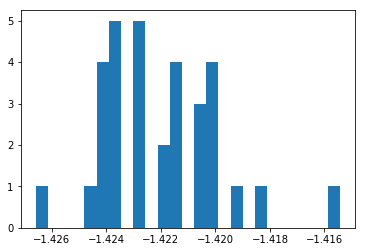

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



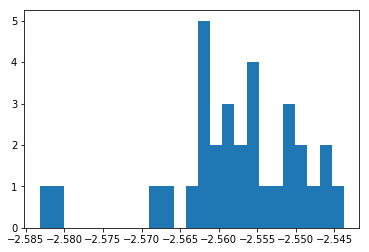

0.00967288017273
Training epoch 121000
Iter: 121000
D loss: 3.515
G_loss: 14.27
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.89368


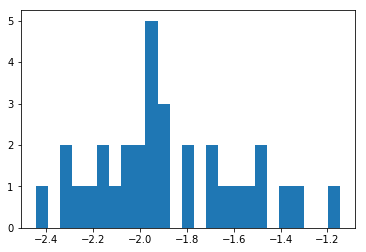

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



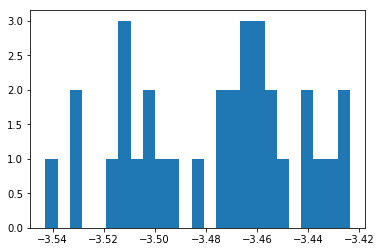

0.00973987579346
Training epoch 122000
Iter: 122000
D loss: 0.06814
G_loss: 15.3
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.56998


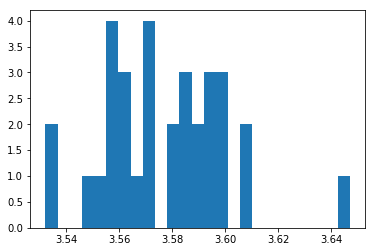

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



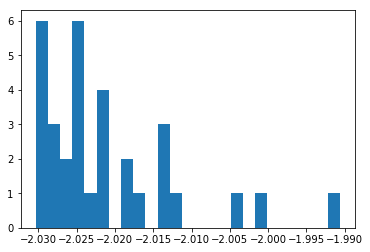

0.0137770175934
Training epoch 123000
Iter: 123000
D loss: 0.1344
G_loss: 15.46
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.51538


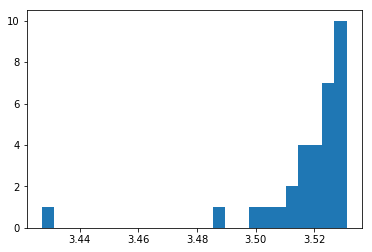

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



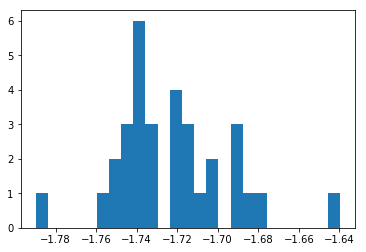

0.00935506820679
Training epoch 124000
Iter: 124000
D loss: 0.02927
G_loss: 15.7
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.98965


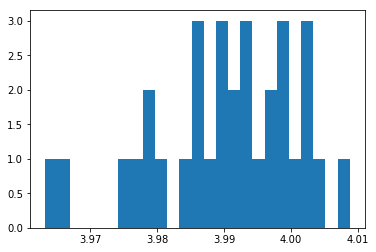

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



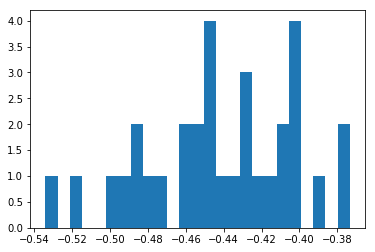

0.00917315483093
Training epoch 125000
Iter: 125000
D loss: 0.1566
G_loss: 15.46
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.51162


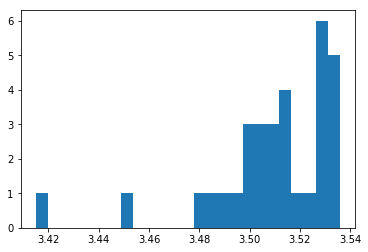

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



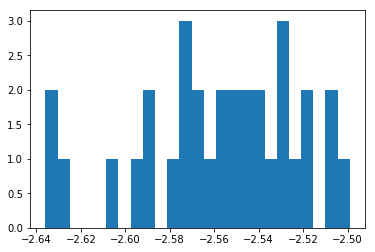

0.00923991203308
Training epoch 126000
Iter: 126000
D loss: 0.02547
G_loss: 15.73
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.97319


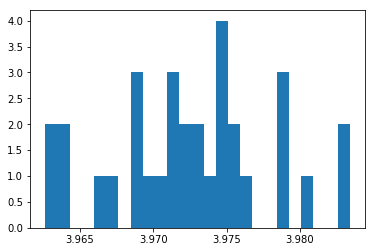

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



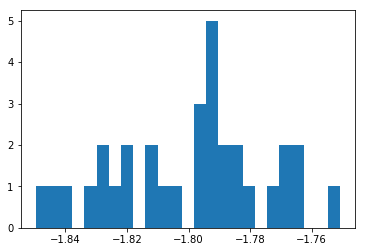

0.00925588607788
Training epoch 127000
Iter: 127000
D loss: 0.1516
G_loss: 15.45
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
4.60193


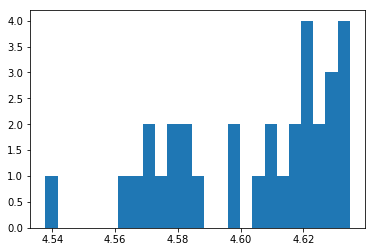

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



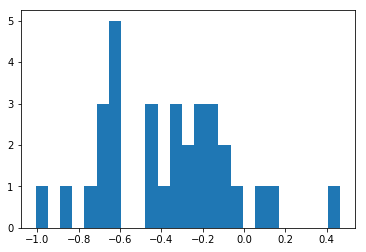

0.0103900432587
Training epoch 128000
Iter: 128000
D loss: 0.1128
G_loss: 15.42
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
4.21874


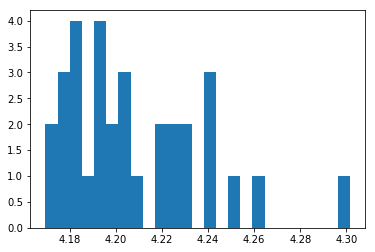

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



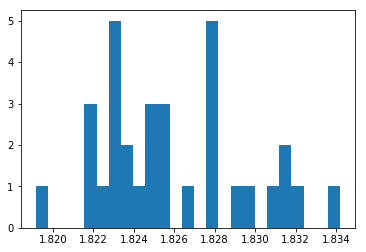

0.00991988182068
Training epoch 129000
Iter: 129000
D loss: 0.1993
G_loss: 15.29
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
4.0955


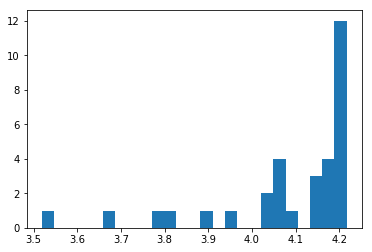

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



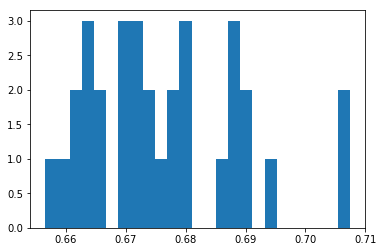

0.00985217094421
Training epoch 130000
Iter: 130000
D loss: 0.4401
G_loss: 15.14
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.668339


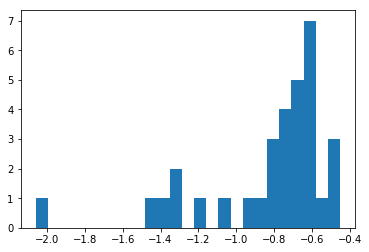

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



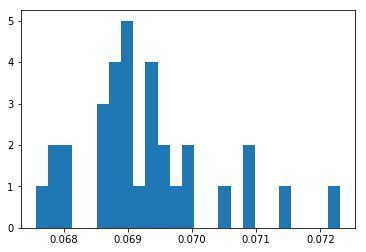

0.0100150108337
Training epoch 131000
Iter: 131000
D loss: 0.1009
G_loss: 15.54
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.673833


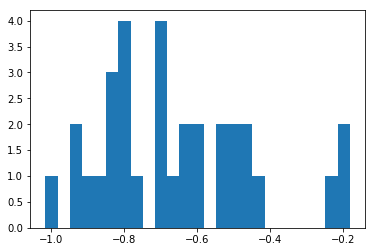

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



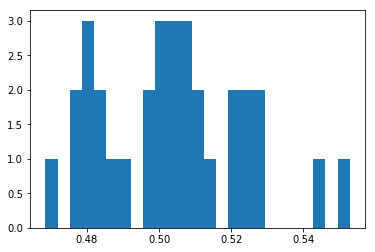

0.00939512252808
Training epoch 132000
Iter: 132000
D loss: 0.2587
G_loss: 15.45
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.04409


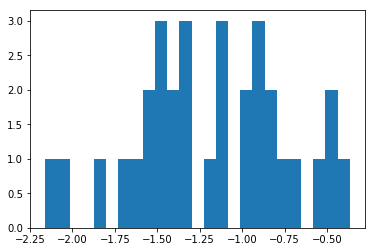

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



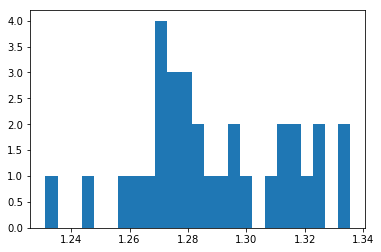

0.00959801673889
Training epoch 133000
Iter: 133000
D loss: 0.5286
G_loss: 15.73
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-3.41697


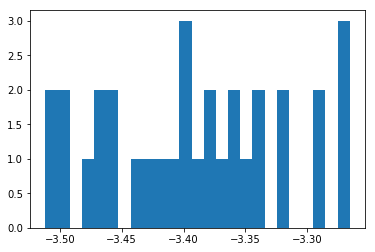

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



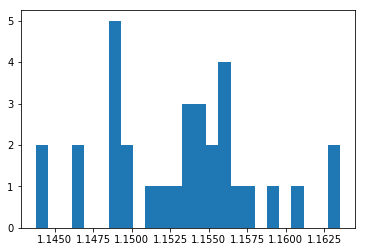

0.00961780548096
Training epoch 134000
Iter: 134000
D loss: 0.2271
G_loss: 14.41
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.52263


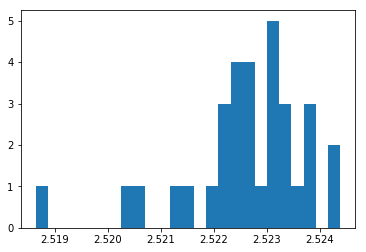

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



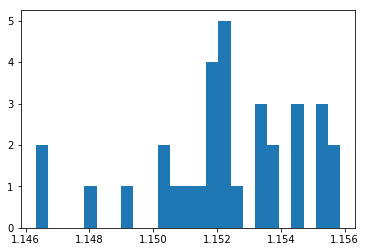

0.00888800621033
Training epoch 135000
Iter: 135000
D loss: 0.1517
G_loss: 15.11
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.5174


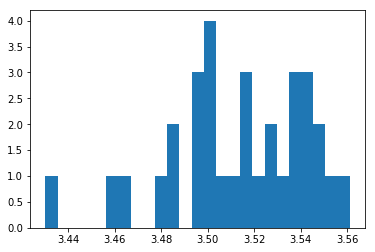

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



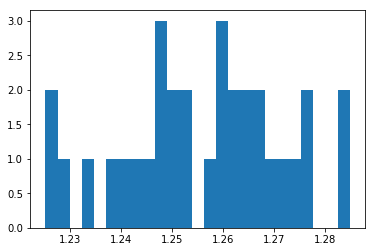

0.00988602638245
Training epoch 136000
Iter: 136000
D loss: 0.011
G_loss: 15.81
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.573692


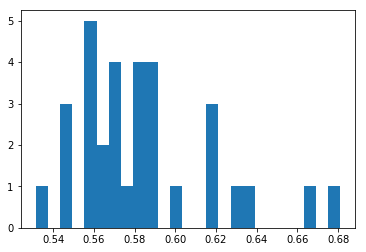

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



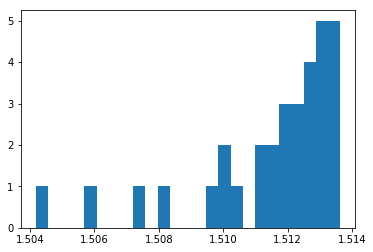

0.00948309898376
Training epoch 137000
Iter: 137000
D loss: 0.2186
G_loss: 15.12
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.7138


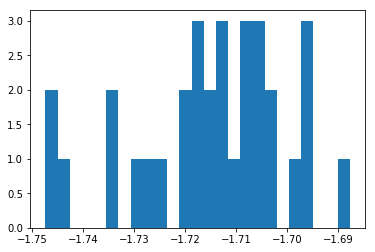

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



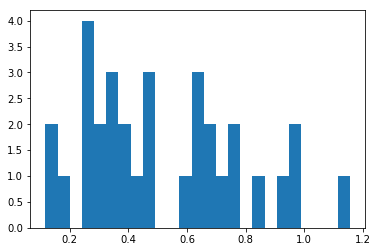

0.00928711891174
Training epoch 138000
Iter: 138000
D loss: 0.05622
G_loss: 15.44
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.997243


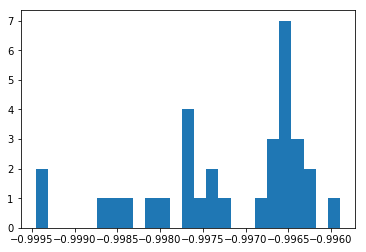

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



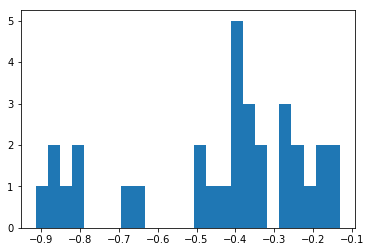

0.00978398323059
Training epoch 139000
Iter: 139000
D loss: 0.08686
G_loss: 15.41
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.535484


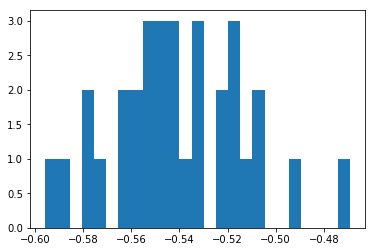

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



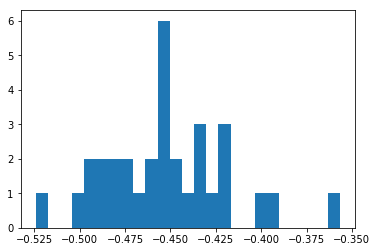

0.00968098640442
Training epoch 140000
Iter: 140000
D loss: 2.696
G_loss: 14.69
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.29531


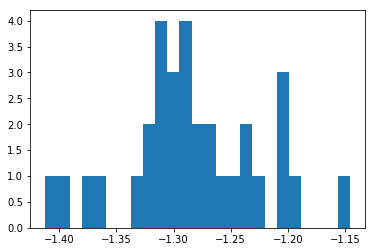

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



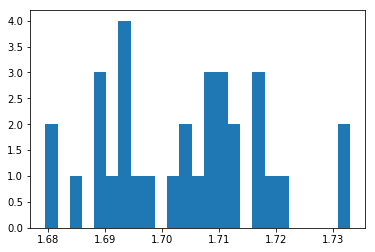

0.00960206985474
Training epoch 141000
Iter: 141000
D loss: 0.06327
G_loss: 15.7
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.731772


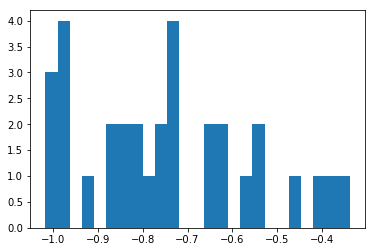

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



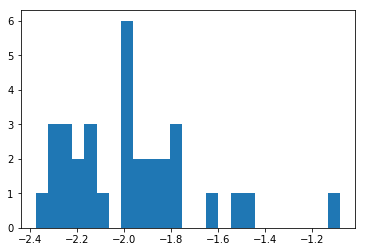

0.00956892967224
Training epoch 142000
Iter: 142000
D loss: 0.04189
G_loss: 15.56
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.54765


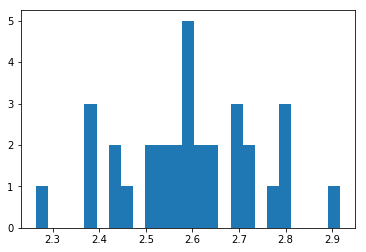

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



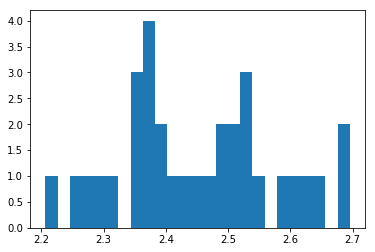

0.00945401191711
Training epoch 143000
Iter: 143000
D loss: 0.1527
G_loss: 14.99
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.36401


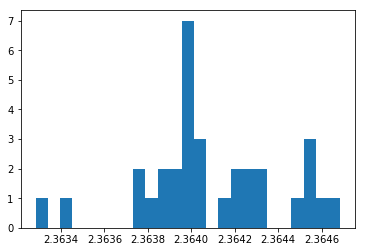

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



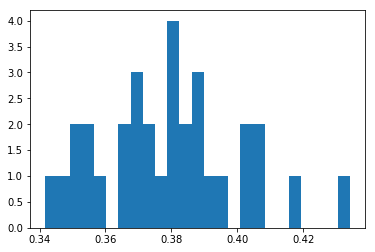

0.00957298278809
Training epoch 144000
Iter: 144000
D loss: 0.3664
G_loss: 15.5
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.45234


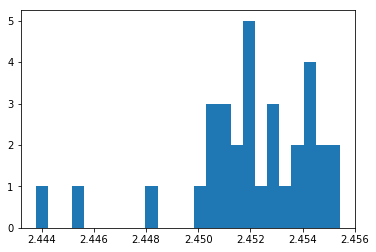

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



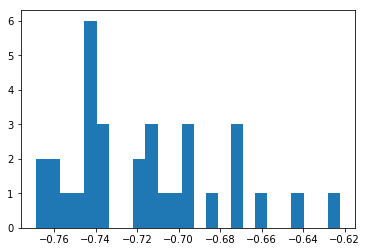

0.00941109657288
Training epoch 145000
Iter: 145000
D loss: 0.3355
G_loss: 15.11
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.5944


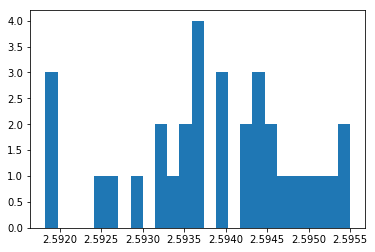

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



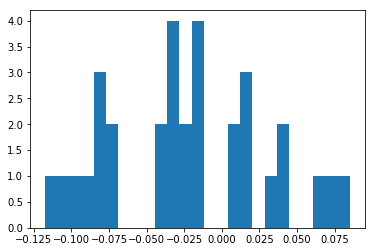

0.00992107391357
Training epoch 146000
Iter: 146000
D loss: 0.6358
G_loss: 15.23
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.27216


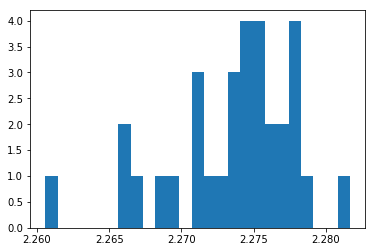

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



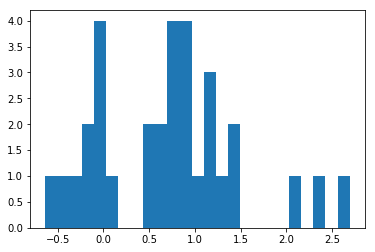

0.00965189933777
Training epoch 147000
Iter: 147000
D loss: 0.3313
G_loss: 15.23
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.44124


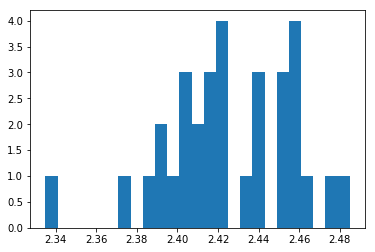

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



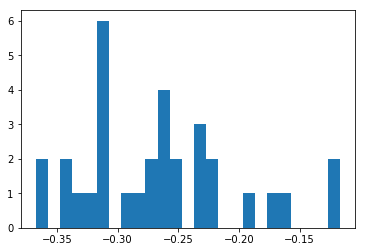

0.00935816764832
Training epoch 148000
Iter: 148000
D loss: 0.3363
G_loss: 15.3
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.79044


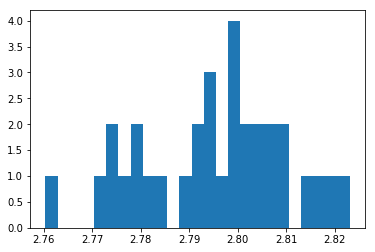

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



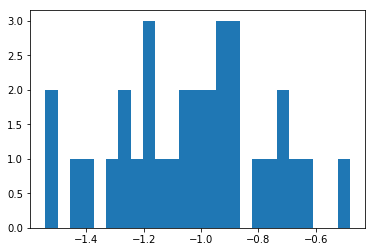

0.00992393493652
Training epoch 149000
Iter: 149000
D loss: 0.3846
G_loss: 15.02
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.03524


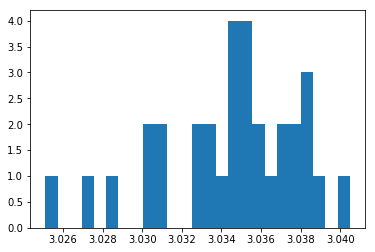

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



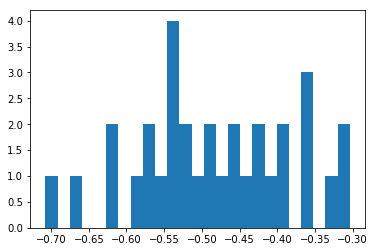

0.00973892211914
Training epoch 150000
Iter: 150000
D loss: 0.2253
G_loss: 15.11
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.10811


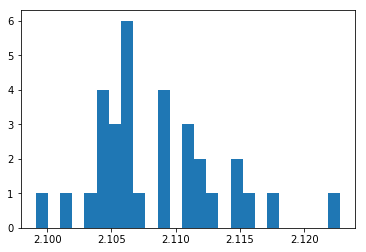

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



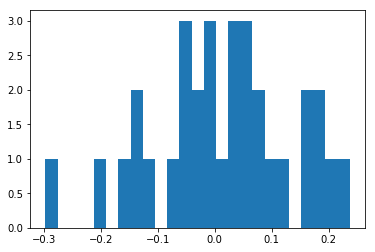

0.0100121498108
Training epoch 151000
Iter: 151000
D loss: 0.03005
G_loss: 15.73
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.38591


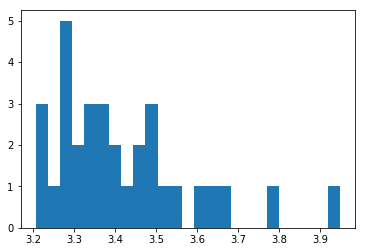

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



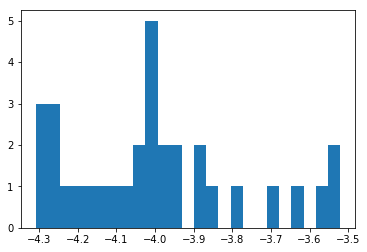

0.00966715812683
Training epoch 152000
Iter: 152000
D loss: 0.07816
G_loss: 15.73
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.32854


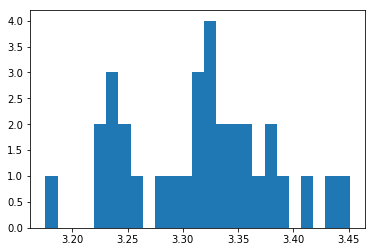

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



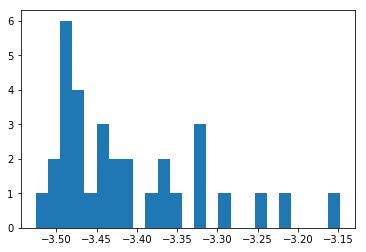

0.00948596000671
Training epoch 153000
Iter: 153000
D loss: 0.7136
G_loss: 14.99
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.22794


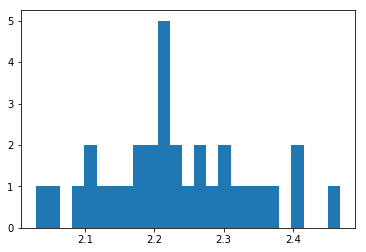

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



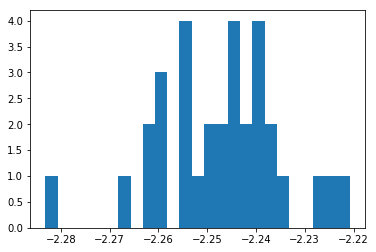

0.00931096076965
Training epoch 154000
Iter: 154000
D loss: 0.01821
G_loss: 15.74
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-2.69073


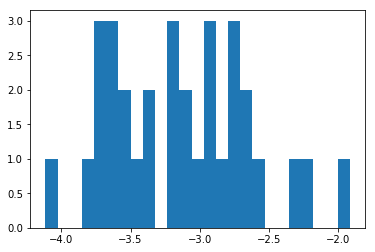

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



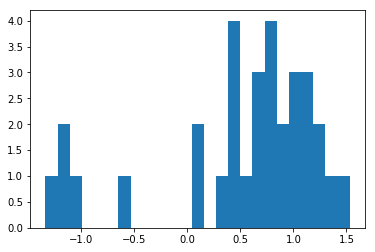

0.00952816009521
Training epoch 155000
Iter: 155000
D loss: 0.01773
G_loss: 15.86
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-4.17572


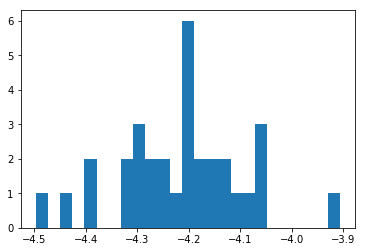

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



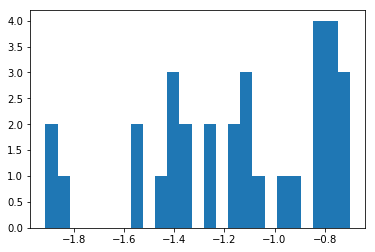

0.00953388214111
Training epoch 156000
Iter: 156000
D loss: 0.001981
G_loss: 15.98
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.80349


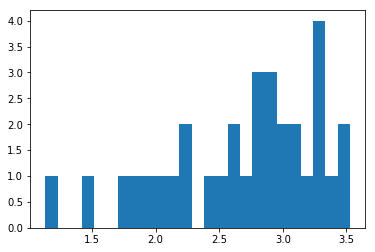

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



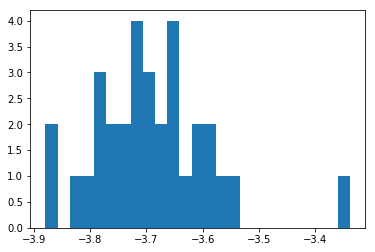

0.0099048614502
Training epoch 157000
Iter: 157000
D loss: 0.05983
G_loss: 15.84
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.53973


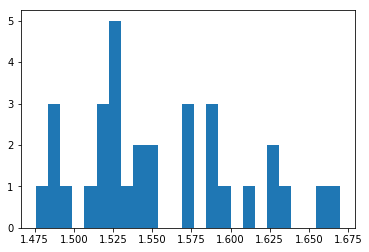

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



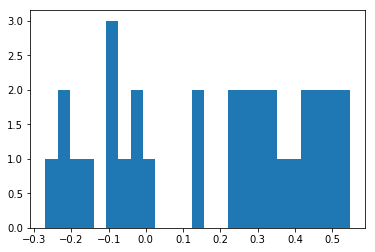

0.00961995124817
Training epoch 158000
Iter: 158000
D loss: 0.07069
G_loss: 15.77
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.53579


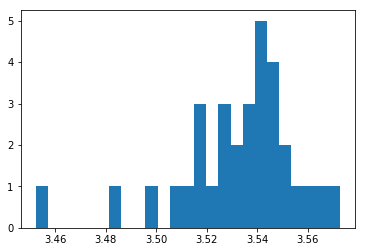

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



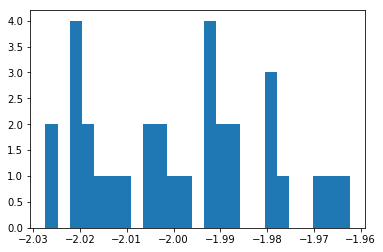

0.00960993766785
Training epoch 159000
Iter: 159000
D loss: 0.03256
G_loss: 15.69
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.92466


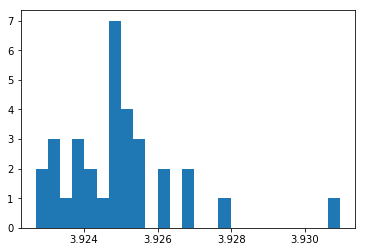

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



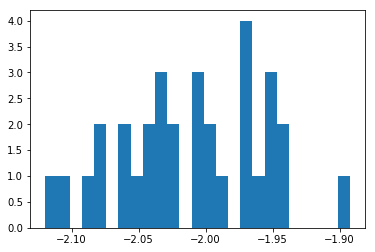

0.00935506820679
Training epoch 160000
Iter: 160000
D loss: 0.01285
G_loss: 15.72
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
4.09188


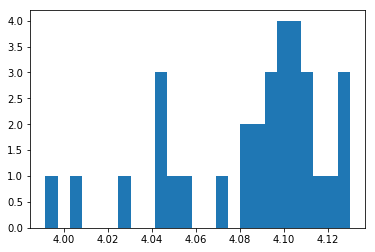

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



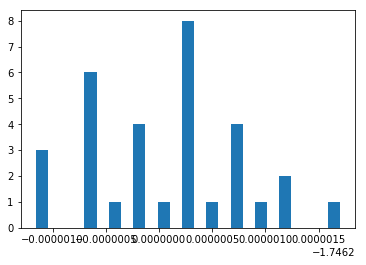

0.00930595397949
Training epoch 161000
Iter: 161000
D loss: 0.05254
G_loss: 15.83
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
4.44138


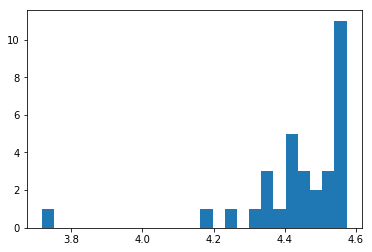

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



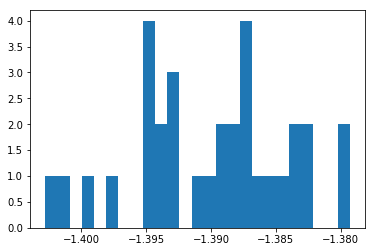

0.00987315177917
Training epoch 162000
Iter: 162000
D loss: 0.08574
G_loss: 15.7
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
5.35666


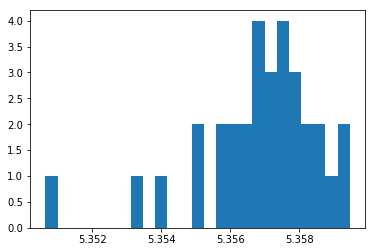

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



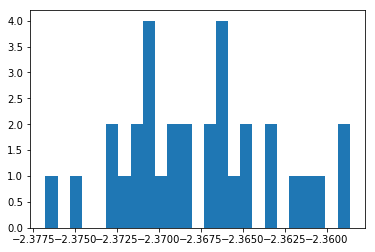

0.00932097434998
Training epoch 163000
Iter: 163000
D loss: 0.5714
G_loss: 15.14
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.62026


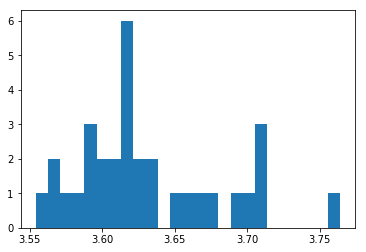

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



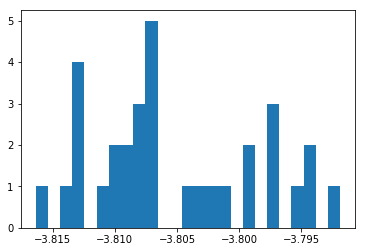

0.00975179672241
Training epoch 164000
Iter: 164000
D loss: 0.01482
G_loss: 15.92
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.918005


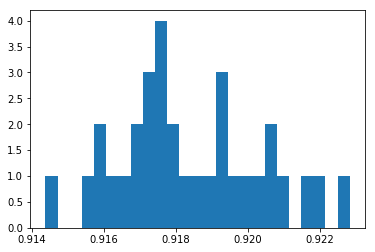

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



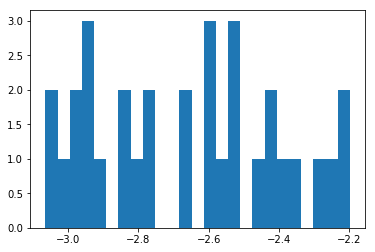

0.0101029872894
Training epoch 165000
Iter: 165000
D loss: 0.1716
G_loss: 15.59
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.955737


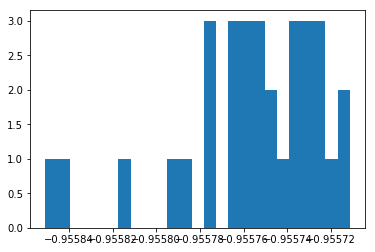

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



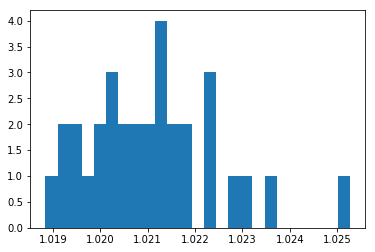

0.00988793373108
Training epoch 166000
Iter: 166000
D loss: 0.1211
G_loss: 15.75
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-3.85485


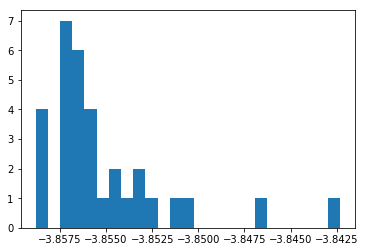

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



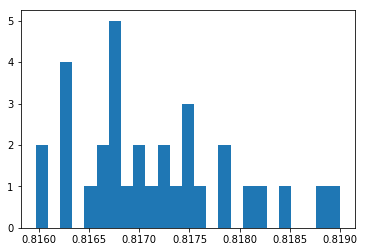

0.00955986976624
Training epoch 167000
Iter: 167000
D loss: 0.001671
G_loss: 15.97
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.20435


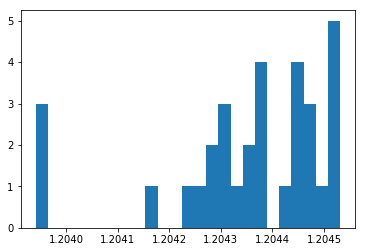

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



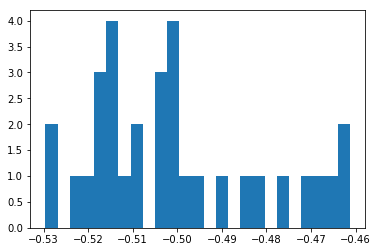

0.00962519645691
Training epoch 168000
Iter: 168000
D loss: 0.002641
G_loss: 15.96
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.737554


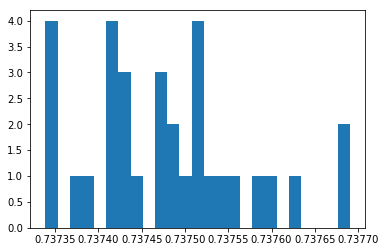

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



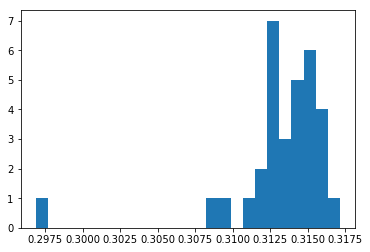

0.0095009803772
Training epoch 169000
Iter: 169000
D loss: 0.1109
G_loss: 15.82
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.98927


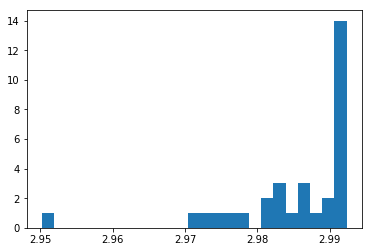

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



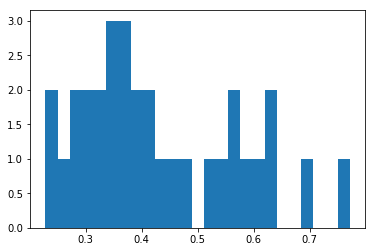

0.00937986373901
Training epoch 170000
Iter: 170000
D loss: 0.1488
G_loss: 15.4
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.60028


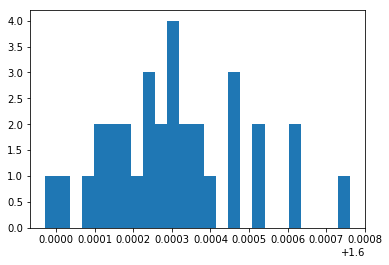

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



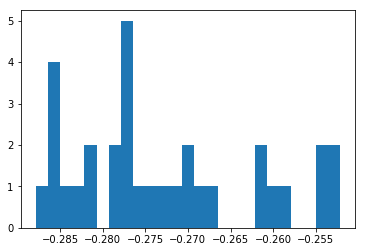

0.0097541809082
Training epoch 171000
Iter: 171000
D loss: 0.4672
G_loss: 15.2
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.251379


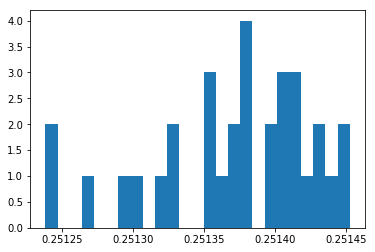

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



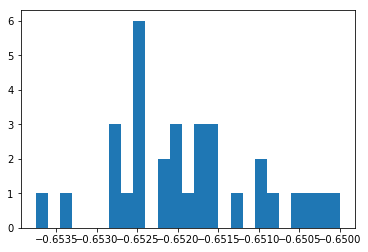

0.00965404510498
Training epoch 172000
Iter: 172000
D loss: 0.07567
G_loss: 15.79
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.19998


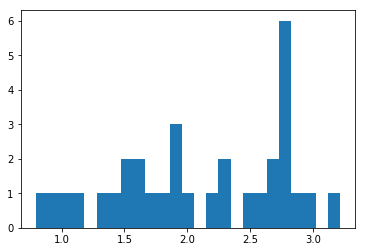

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



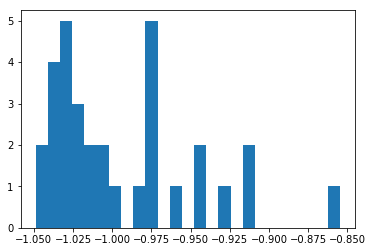

0.00992798805237
Training epoch 173000
Iter: 173000
D loss: 0.1059
G_loss: 15.48
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.59953


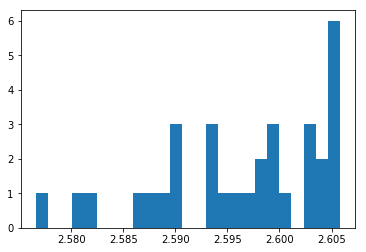

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



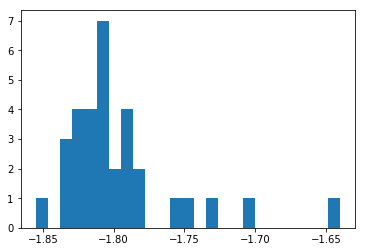

0.00965690612793
Training epoch 174000
Iter: 174000
D loss: 0.009441
G_loss: 15.86
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.56369


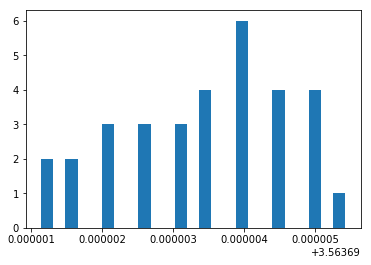

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



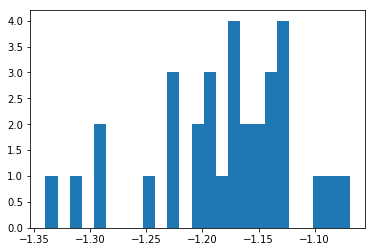

0.00982713699341
Training epoch 175000
Iter: 175000
D loss: 0.05012
G_loss: 15.69
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.798415


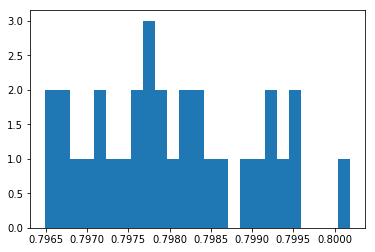

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



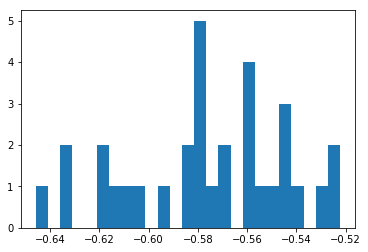

0.0094039440155
Training epoch 176000
Iter: 176000
D loss: 0.001946
G_loss: 15.98
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.21514


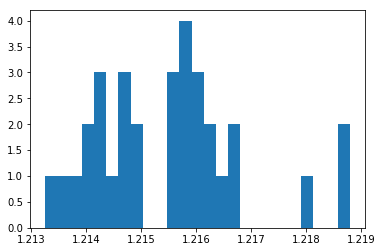

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



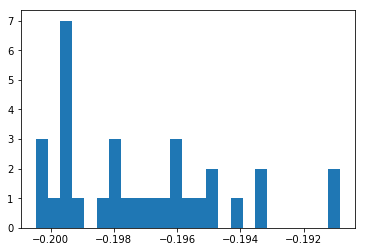

0.00978589057922
Training epoch 177000
Iter: 177000
D loss: 0.5023
G_loss: 15.93
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
5.74554


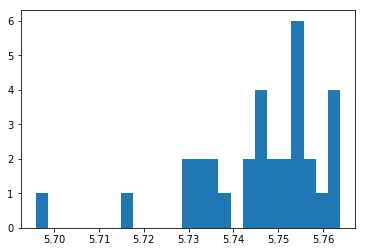

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



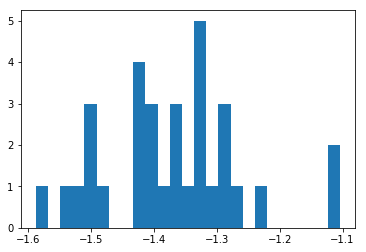

KeyboardInterrupt: 

In [735]:
every = 1000
train_dataset = features[:32]
#train_dataset = features[:1]*S
n_train = len(train_dataset)

for it in range(1000000):
    a = time.time()
    random.shuffle(train_dataset)
    
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        

        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, D_loss_curr = sess.run(
            [D_solver, D_loss] + d_ops, feed_dict=feed_dict)[0:2]
        
        _, G_loss_curr = sess.run([G_solver, G_loss] + g_ops, feed_dict=feed_dict)[0:2]
        
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)
    
    if it % every == 0:
        
        print(time.time()-a)
        print("Training epoch %d" %it)
                
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        feed_dict = construct_feed_dict(features[:1]*S, 0, S, shuffle_inds=False, keep_prob_val=1., train=False)
        
        print("4wks:\n")
        
        print("real:")
        print(feed_dict[mol_xyz][0][:4])
        print("fake:")
        print(sess.run(G_sample, feed_dict=feed_dict)[0][:4])
        print("fake:")
        print(sess.run(rot_mat_i, feed_dict=feed_dict))

        print(np.mean(sess.run(dihed_tensor, feed_dict=feed_dict)[:, 0]))
        print(np.mean(sess.run(dihed, feed_dict=feed_dict)[:, 0]))
        plt.hist(sess.run(dihed, feed_dict=feed_dict)[:, 0], bins=25)
        plt.show()
        
        
        generate_molecule(features[0][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[0][0].split(".")[0].split("/")[-1], it))
        
        print("Butane:\n")
        feed_dict = construct_feed_dict(features[len(features)-32:], 0, S, shuffle_inds=False, keep_prob_val=1., train=False)
        plt.hist(sess.run(dihed, feed_dict=feed_dict)[:, 0], bins=25)
        plt.show()
        #generate_molecule(features[1][0], sess.run(G_sample, feed_dict=feed_dict)[1], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[1][0].split(".")[0].split("/")[-1], it))

        #feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False, keep_prob_val=1.)
        #generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))

        
        

        #print("output_i")
        #print(sess.run(G_sample_output_i, feed_dict=feed_dict))
        #print(sess.run(G_sample, feed_dict=feed_dict))

    #random.shuffle(train_dataset)



In [189]:
features[4]

('/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2',
 array([[-0.0725, -0.0715, -1.7212],
        [-0.8925,  0.3145, -0.4713],
        [-0.2245, -0.1035,  1.0027],
        [ 1.1895, -0.1395,  1.1898],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],


In [ ]:
every = 1000
#train_dataset = features[:96]
train_dataset = features[:1]*S
n_train = len(train_dataset)

for it in range(1000000):
    a = time.time()
    random.shuffle(train_dataset)
    
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        
        for _ in range(5):
            feed_dict = construct_feed_dict(train_dataset, start, stop)

            _, D_loss_curr, _ = sess.run(
                [D_solver, D_loss, clip_D], feed_dict=feed_dict)
        
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)
        
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)
    
    if it % every == 0:
        
        print(time.time()-a)
        print("Training epoch %d" %it)
                
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        feed_dict = construct_feed_dict(features[:1]*S, 0, S, shuffle_inds=False, keep_prob_val=1.)
        
        print("4wks:\n")
        
        print("real:")
        print(feed_dict[mol_xyz][0][:4])
        print("fake:")
        print(sess.run(G_sample, feed_dict=feed_dict)[0][:4])
        print("fake:")
        print(sess.run(rot_mat_i, feed_dict=feed_dict))

        print(np.mean(sess.run(dihed, feed_dict=feed_dict)[:, 0]))
        plt.hist(sess.run(dihed, feed_dict=feed_dict)[:, 0])
        plt.show()
        
        
        generate_molecule(features[0][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[0][0].split(".")[0].split("/")[-1], it))
        
        print("Butane:\n")
        feed_dict = construct_feed_dict(features[len(features)-32:], 0, S, shuffle_inds=False, keep_prob_val=1.)
        plt.hist(sess.run(dihed, feed_dict=feed_dict)[:, 0])
        plt.show()
        #generate_molecule(features[1][0], sess.run(G_sample, feed_dict=feed_dict)[1], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[1][0].split(".")[0].split("/")[-1], it))

        #feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False, keep_prob_val=1.)
        #generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))

        
        

        #print("output_i")
        #print(sess.run(G_sample_output_i, feed_dict=feed_dict))
        #print(sess.run(G_sample, feed_dict=feed_dict))

    #random.shuffle(train_dataset)



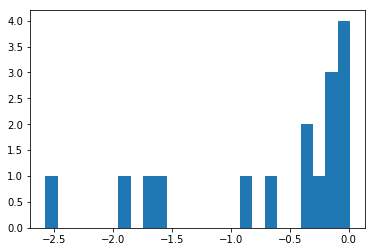

In [321]:
S=16
feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False)

plt.hist(np.squeeze(sess.run(dihed, feed_dict=feed_dict)), bins=25)
plt.show()

In [216]:
features[1]

('/home/evan/Documents/deep_docking/datasets/v2015/2ohk/2ohk_ligand.mol2',
 array([[-1.2731,  0.9987, -2.2001],
        [-0.5031,  1.0397, -1.0801],
        [-0.0411,  2.2447, -0.6841],
        [ 0.7269,  2.2857,  0.4109],
        [ 1.0309,  1.1747,  1.1729],
        [ 0.5309, -0.0663,  0.8089],
        [ 0.7909, -1.2213,  1.5379],
        [ 0.2719, -2.4343,  1.1299],
        [-0.4991, -2.5073, -0.0101],
        [-0.7681, -1.3733, -0.7401],
        [-0.2671, -0.1413, -0.3461],
        [ 0.    ,  0.    ,  0.    ]]),
 array([[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]], dtype=uint8),
 array([[ 0.]]),
 array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0

In [ ]:
feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False)
generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))


In [ ]:
np.min(results[0])



In [ ]:
np.where(features[0][1][:,:,:,:-1] == 1)

In [ ]:
"""
def discriminator(W_list, b_list, h_list, L_list, n_layers, mols):
    mols = tf.add(mols, mol_noise)
    with tf.device('/gpu:0'):
        for layer_idx in range(n_layers):
            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                             b_list[layer_idx], adj_list[layer_idx], 
                                             clades_list[layer_idx],
                                             L_list[layer_idx], L_list[layer_idx+1],
                                             layer_idx, S, B_list[layer_idx]), keep_prob))
        h_final = h_list[-1]
        dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols, S, axis=0)], axis=0)
        print("dist_matrix")
        print(dist_matrix)
        #dist_matrix = compute_distance_matrix(mol)
        bond_dist_gen = tf.multiply(dist_matrix, adj_matrix)
        wrong_bond_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(bond_dist_mat, bond_dist_gen)), axis=[1,2]), lam1), (S,1)), n_bonds)
        print("wrong_bond_loss")
        print(wrong_bond_loss)

        angles = []
        for i in range(0, B):
            for j in range(0, B):
                ij = mols[:, i,:] - mols[:,j,:]
                ij = ij / tf.sqrt(tf.reduce_sum(tf.square(ij), 1, keep_dims=True))
                #ij shape should be (S, 3)
               # print("ij")
                #print(ij)
                for k in range(0,B):
                    ik = mols[:,i,:] - mols[:,k,:]
                    ik = ik / tf.sqrt(tf.reduce_sum(tf.square(ik), 1, keep_dims=True))

                    #ik shape should be (S, 3)
                    #if i == 0 and j == 0 and k == 0: 
                    #   print("ik")
                     #   print(ik)
                        
                    dp = tf.reduce_sum(tf.multiply(ij, ik), axis=1, keep_dims=True)
                    #dp shape should be (S,1)
                    #if i ==0 and j ==0 and k==0:
                    #    print("dp")
                    #    print(dp)
                    if i == j or i == k or j == k:
                        angle = tf.Variable(tf.constant(np.zeros([4,1]).astype(np.float32)))
                    else:
                        angle = tf.acos(tf.clip_by_value(tf.reduce_sum(tf.multiply(ij, ik), axis=1, keep_dims=True), -1.0, 1.0))
                    #if i ==0 and j==0 and k==0:
                        #print("angle")
                        #print(angle)
                    angles.append(angle)
        angles_gen = tf.reshape(tf.concat(angles, axis=1), [S, B, B, B])
        angles_gen = tf.multiply(angles_gen, angle_tuples)
        wrong_angles_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(angle_tensor, angles_gen)), axis=[1,2,3]), lam2), (S,1)), n_angles)
                
        feat_i = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_i = tf.tile(feat_i, [1, 1, B, 1])
        
        feat_j = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_j = tf.transpose(feat_j, perm=[0, 2, 1, 3])
        feat_j = tf.tile(feat_j, [1, B, 1, 1])
        
        d_h1 = tf.concat([tf.reshape(dist_matrix, [S, B, B, 1]), feat_i, feat_j], axis=3)
        d_h1 = tf.reshape(d_h1, [S, B, B*(L_list[n_layers]*2+1)])
        d_h2 = tf.nn.sigmoid(tf.matmul(d_h1, d_w1) + d_b1)
        d_h2 = tf.divide(tf.reduce_sum(tf.matmul(d_h2, d_w2) + d_b2, axis=1), n_bonds)#, axis=1
        print("d_h2")
        print(d_h2)
        
    
    return(wrong_bond_loss + wrong_angles_loss + d_h2, bond_dist_gen, angles_gen, wrong_bond_loss, wrong_angles_loss)
"""

In [ ]:
mol = Chem.MolFromMol2File(ligand_files[0])
c = mol.GetConformer(0)

In [ ]:
c.SetAtomPosition(0, [0., 0., 0.])

In [ ]:
np.where(features[2][1][:,:,:,:-1] == 1)

In [ ]:
results = sess.run(G_sample, feed_dict=feed_dict)

In [ ]:
sess.run(pred_real, feed_dict=feed_dict)

In [ ]:
np.max(results[0][:,:,:,:], axis=-1)

In [ ]:
features[1][0]

In [ ]:
mol = Chem.MolFromMol2File(features[1][0])
mol.GetNumAtoms()

In [ ]:
from rdkit.Chem import AllChem
AllChem.Compute2DCoords(mol)

In [ ]:
from rdkit.Chem import Draw

Draw.MolToImage(mol)